<a href="https://colab.research.google.com/github/tngjody/bt4221-airfare-booking/blob/main/BT4221_Group_20.ipynb" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
&nbsp;
<a href="https://community.cloud.databricks.com/editor/notebooks/139383512168441?o=887419768098030#command/139383512168442" target="_blank">
  <img src="https://img.shields.io/badge/Open%20in-Databricks-orange?logo=databricks" alt="Open In Databricks"/>
</a>

# BT4221 Group 20: Optimising Airfare Booking with Predictive Analytics

Group Members:

Gong Yongjia A0286144X

Jody Tng Jin Zi A0238195W

Wu Shuhan A0266501L

Zhou Jingchu Jeslyn A0275993H

## ✈️ **Overview**

This project aims to **predict the optimal time to book flight tickets** based on a traveler’s destination and departure date, by analyzing historical pricing data.  

📉 The *optimal booking time* is defined as the period when the fare falls **below the 25th percentile** of historical price distributions for similar routes. This helps travelers identify the **lowest possible fare** for their desired routes.

Flight prices fluctuate due to various factors, making it difficult for travelers to determine the best time to book. By leveraging 🧠 **machine learning techniques**, our project provides **data-driven insights** to optimize travel planning.

💼 This can benefit both:
- **Individual travelers** looking for cost savings
- **Businesses** managing corporate travel budgets

---

## 🔍 **Focus Areas**
- 📊 Predicting future flight ticket prices based on historical data  
- 📈 Identifying trends and patterns that indicate the best time to purchase tickets  
- 📆 Analyzing factors such as **seasonality** and **booking windows**

---

## 🚫 **Exclusions**
- ❌ Real-time tracking of ticket prices  
- ❌ External factors like airline-specific promotional deals, last-minute fare changes, or global events and government regulations



# **1. Importing Libraries and Dataset**

In [1]:
# PySpark Session & Core
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import (
    col,
    isnan,
    when,
    percentile_approx,
    mean,
    stddev,
    count,
    avg,
    min,
    max, 
    log,
)
from pyspark.sql.types import (
    NumericType,
    DoubleType,
    DateType,
    StringType,
)

# PySpark MLlib (Features, Pipeline, Models, Evaluators)
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    StringIndexer,
    OneHotEncoder,
    VectorAssembler,
    StandardScaler,
    PCA,
)
from pyspark.ml.stat import Correlation
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator 
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Python Standard Libraries
import math
from datetime import datetime, timedelta
from scipy import stats

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## **1.1. Initialize Spark Session & Load Dataset**

In [ ]:
# Initialize Spark Sesison
spark = SparkSession.builder.appName("FlightPrices").getOrCreate()

# Load Dataset
flight_df = spark.read.csv("flight.csv", header=True, inferSchema=True)

# Show a sample (5 rows) of the data
flight_df.show(5, truncate=False)

# Display schema
flight_df.printSchema()

+--------------------------------+----------+----------+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+---------------------------------+------------------------------------------------------------+-------------------------------+------------------------------------------------------------+--------------------------+----------------------------+-------------------+-------------------+------------------------------+-------------------------+----------------+-----------------+
|legId                           |searchDate|flightDate|startingAirport|destinationAirport|fareBasisCode|travelDuration|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|segmentsDepartureTimeEpochSeconds|segmentsDepartureTimeRaw                                    |segmentsArrivalTimeEpochSeconds|segmentsArrivalTimeRaw                          

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 53493)
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\socketserver.py", line 755, in __init__
    self.handle()
  File "C:\Users\tngjo\AppData\Local\Packages\Pyt

## **1.2 EDA on Raw Data**

In [5]:
flight_df.filter(F.col("totalTravelDistance").isNull()) \
    .select("legid", "totalTravelDistance", "segmentsDistance") \
    .show(5, truncate=False)

+--------------------------------+-------------------+----------------+
|legid                           |totalTravelDistance|segmentsDistance|
+--------------------------------+-------------------+----------------+
|2d27f28ea39de6e1cc0b0f17d8f8fa8b|NULL               |None||None      |
|8f831229e4db64d5868f04845d6ddc89|NULL               |None||None      |
|9661f8606b490c94e3590486ed558cbf|NULL               |None||None      |
|fde2c64a4b9875e0bdb316cb8606c213|NULL               |None            |
|b9276bd7af0f52933bd9c48785a63ae3|NULL               |None||None      |
+--------------------------------+-------------------+----------------+
only showing top 5 rows



#### **Observation**

We noticed that when `totalTravelDistance` is not available, the corresponding `segmentsDistance` is also unavailable. This observation suggests that missing values in `totalTravelDistance` are directly tied to missing values in `segmentsDistance`. Therefore, any imputation or handling of missing data should consider this relationship to maintain data consistency.

### **1.2.1 Numeric Data Analysis**

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 12.0 failed 1 times, most recent failure: Lost task 0.0 in stage 12.0 (TID 87) (yongjia executor driver): java.net.SocketException: Connection reset
	at java.base/sun.nio.ch.NioSocketImpl.implRead(NioSocketImpl.java:323)
	at java.base/sun.nio.ch.NioSocketImpl.read(NioSocketImpl.java:350)
	at java.base/sun.nio.ch.NioSocketImpl$1.read(NioSocketImpl.java:803)
	at java.base/java.net.Socket$SocketInputStream.read(Socket.java:966)
	at java.base/java.io.BufferedInputStream.fill(BufferedInputStream.java:244)
	at java.base/java.io.BufferedInputStream.read(BufferedInputStream.java:263)
	at java.base/java.io.DataInputStream.readInt(DataInputStream.java:393)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:774)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1049)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2433)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2458)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1049)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1048)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:195)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: java.net.SocketException: Connection reset
	at java.base/sun.nio.ch.NioSocketImpl.implRead(NioSocketImpl.java:323)
	at java.base/sun.nio.ch.NioSocketImpl.read(NioSocketImpl.java:350)
	at java.base/sun.nio.ch.NioSocketImpl$1.read(NioSocketImpl.java:803)
	at java.base/java.net.Socket$SocketInputStream.read(Socket.java:966)
	at java.base/java.io.BufferedInputStream.fill(BufferedInputStream.java:244)
	at java.base/java.io.BufferedInputStream.read(BufferedInputStream.java:263)
	at java.base/java.io.DataInputStream.readInt(DataInputStream.java:393)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:774)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1049)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2433)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more


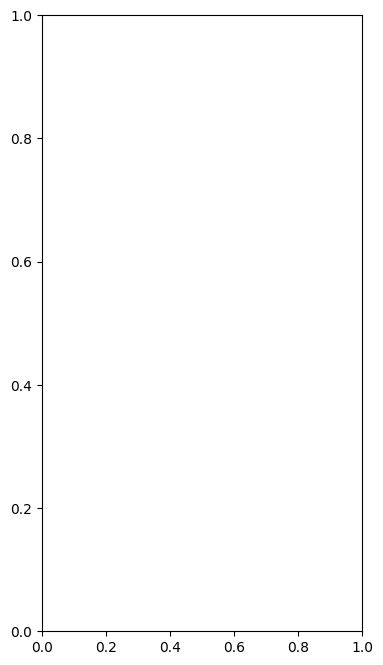

In [16]:
# Box plot for numeric data
def create_pyspark_boxplots(df, columns):
    plt.figure(figsize=(24, 8))

    for i, column in enumerate(columns, 1):
        plt.subplot(1, len(columns), i)

        # Collect numeric data
        data = (
            df.select(column)
            .rdd.flatMap(lambda x: x)
            .filter(lambda x: x is not None)
            .collect()
        )

        # Create boxplot
        plt.boxplot(
            data,
            patch_artist=True,
            boxprops=dict(facecolor="lightblue", color="blue"),
            medianprops=dict(color="red"),
            flierprops=dict(
                marker="o", markerfacecolor="red", markersize=5, linestyle="none"
            ),
        )

        # Compute detailed statistics for the column
        stats = df.agg(
            count(column).alias("total_count"),
            mean(column).alias("mean"),
            stddev(column).alias("std"),
            percentile_approx(column, [0.01, 0.25, 0.5, 0.75, 0.99]).alias(
                "percentiles"
            ),
        ).collect()[0]

        # Extract statistics
        total_count = stats["total_count"]
        mean_val = stats["mean"]
        std_val = stats["std"]
        percentiles = stats["percentiles"]
        q1, median, q3 = percentiles[1], percentiles[2], percentiles[3]
        iqr = q3 - q1

        # Identify outliers
        outliers = df.filter(
            (col(column) < percentiles[1] - 1.5 * (percentiles[3] - percentiles[1]))
            | (col(column) > percentiles[3] + 1.5 * (percentiles[3] - percentiles[1]))
        )
        outliers_count = outliers.count()

        plt.title(f"{column} Distribution", fontsize=12)
        plt.ylabel(column, fontsize=10)

        # Add text annotations with detailed statistical analysis
        plt.text(
            1.2,
            0.95,
            f"Total Count: {total_count:,}\n"
            f"Mean: {mean_val:.2f}\n"
            f"Std Dev: {std_val:.2f}\n"
            f"Percentiles:\n"
            f"  1st: {percentiles[0]:.2f}\n"
            f"  25th (Q1): {q1:.2f}\n"
            f"  50th (Median): {median:.2f}\n"
            f"  75th (Q3): {q3:.2f}\n"
            f"  99th: {percentiles[4]:.2f}\n"
            f"IQR: {iqr:.2f}\n"
            f"Outliers: {outliers_count:,}",
            transform=plt.gca().transAxes,
            verticalalignment="top",
            horizontalalignment="left",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7),
        )

        plt.grid(axis="y", linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.suptitle("Boxplot Analysis for Numerical Data", fontsize=16, y=1.02)
    plt.show()


# Histograms for numeric data
def create_pyspark_histograms(df, columns):
    plt.figure(figsize=(16, 12))

    for i, column in enumerate(columns, 1):
        plt.subplot(2, 3, i)

        # Collect numeric data
        data = (
            df.select(column)
            .rdd.flatMap(lambda x: x)
            .filter(lambda x: x is not None)
            .collect()
        )

        # Create histogram
        plt.hist(data, bins=30, alpha=0.7, edgecolor="black")

        # Compute comprehensive statistics
        stats = df.agg(
            count(column).alias("total_count"),
            mean(column).alias("mean"),
            stddev(column).alias("std"),
            percentile_approx(column, [0.01, 0.25, 0.5, 0.75, 0.99]).alias(
                "percentiles"
            ),
        ).collect()[0]

        # Add statistical annotations
        plt.title(f"{column} Distribution", fontsize=12)
        plt.xlabel(column, fontsize=10)
        plt.ylabel("Frequency", fontsize=10)

        # Annotate with statistics
        plt.text(
            0.95,
            0.95,
            f'Total Count: {stats["total_count"]:,}\n'
            f'Mean: {stats["mean"]:.2f}\n'
            f'Std Dev: {stats["std"]:.2f}\n'
            f"Percentiles:\n"
            f'  1st: {stats["percentiles"][0]:.2f}\n'
            f'  Median: {stats["percentiles"][2]:.2f}\n'
            f'  99th: {stats["percentiles"][4]:.2f}',
            transform=plt.gca().transAxes,
            verticalalignment="top",
            horizontalalignment="right",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7),
        )

    plt.tight_layout()
    plt.suptitle("Histogram Analysis for Numerical Data", fontsize=16, y=1.02)
    plt.show()


def run_pyspark_analysis(df):
    numeric_cols = [col for col, dtype in df.dtypes if dtype in ("int", "double")]

    # Create visualizations
    create_pyspark_boxplots(df, numeric_cols)
    create_pyspark_histograms(df, numeric_cols)


run_pyspark_analysis(flight_df)

### **Observations**

This initial exploratory analysis of the **numerical raw data** aims to understand the distribution, spread, and potential anomalies of key numerical features in the dataset using both boxplots and histograms. 

By analyzing statistical summaries and visual patterns, we can derive meaningful insights about user behavior, pricing structure, and operational trends.

---

#### **1. `elapsedDays`: Days Between Booking and Travel**

- **Boxplot Observation**: The median, 25th, and 75th percentiles are all 0, with an interquartile range (IQR) of 0. A high number of outliers (302,086) indicates that although most records represent same-day bookings, a minority of users book 1 or more days in advance.
- **Histogram Observation**: The distribution is heavily right-skewed, with an overwhelming majority of bookings made on the day of travel. A secondary peak at 1 confirms a smaller, but still significant, group who book one day in advance.

**Interpretation**: The data suggests a predominantly last-minute booking pattern, which could be characteristic of either business travelers or high-frequency commuters. This insight might influence promotional strategies or dynamic pricing models aimed at encouraging earlier bookings.

---

#### **2. `baseFare`: Base Fare Before Additional Charges**

- **Boxplot Observation**: A median of 305.12 and IQR of 257.67 show moderate variability. However, the presence of over 25,000 outliers and a long upper tail indicates that some routes or classes command very high fares.
- **Histogram Observation**: The distribution is unimodal and highly skewed to the right. Most values cluster below 1000, with very few extreme cases pulling the mean upward (mean = 333.35).

**Interpretation**: While most customers are paying moderate fares, premium travel options or longer-distance routes result in a small subset of high-paying transactions. Pricing strategies could be revisited to manage this skewness or to segment customers based on fare distribution.

---

#### **3. `totalFare`: Total Amount Paid by Customers**

- **Boxplot Observation**: Similar to `baseFare`, the `totalFare` distribution also shows significant skewness. The median is slightly higher at 353.60, and the number of outliers (26,486) reflects variability due to optional add-ons like seat upgrades, baggage, etc.
- **Histogram Observation**: The distribution resembles that of `baseFare`, reinforcing that most customers pay under 1000 units in total, though the tail shows that some pay significantly more.

**Interpretation**: Additional charges are either modest or consistent with base fare patterns. Marketing teams could use this to understand conversion rates for ancillary services or upselling effectiveness.

---

#### **4. `seatsRemaining`: Available Seats at Time of Booking**

- **Boxplot Observation**: The variable is well-distributed with a median of 7, and an IQR of 5. There are no outliers, indicating a controlled and uniform seat release or booking behavior.
- **Histogram Observation**: The data shows clear peaks at values like 0 and 10, indicating that flights are often either fully booked or just opened. Intermediate values are less common but still reasonably distributed.

**Interpretation**: Seat availability reflects both booking cycle dynamics and possibly batch seat releases by airlines. Peaks at full capacity or fully open flights might hint at booking surges at specific intervals. Airlines may want to optimize visibility or pricing strategies based on booking windows.

---

#### **5. `totalTravelDistance`: Total Distance of Journey**

- **Boxplot Observation**: With a median of 1392 and IQR of 1521, this variable shows a wide range, but no outliers were detected. This indicates consistent but diverse travel patterns.
- **Histogram Observation**: A bimodal pattern is observed, with peaks around 500–1000 km and 2300–2500 km. This strongly suggests the existence of distinct travel categories—short-haul and long-haul journeys.

**Interpretation**: Recognizing these distance clusters can help in route-based customer segmentation or classifying ticket types. Airlines or transport providers could tailor their services, promotions, and aircraft types to suit the dominant distance ranges.

---

#### **Overall Summary**

This combined analysis of boxplots and histograms reveals several patterns:

- **Heavy right-skewness** in fare-related features (`baseFare`, `totalFare`) and **booking behavior** (`elapsedDays`).
- **High concentration at 0 days** for `elapsedDays`, reflecting mostly last-minute bookings.
- **Consistent seat availability** with edge peaks at 0 and 10, suggesting batch dynamics or high demand during certain periods.
- **Clear distinction in journey lengths** as indicated by the bimodal shape in `totalTravelDistance`.


### **1.2.2 Categorical Data Analysis**

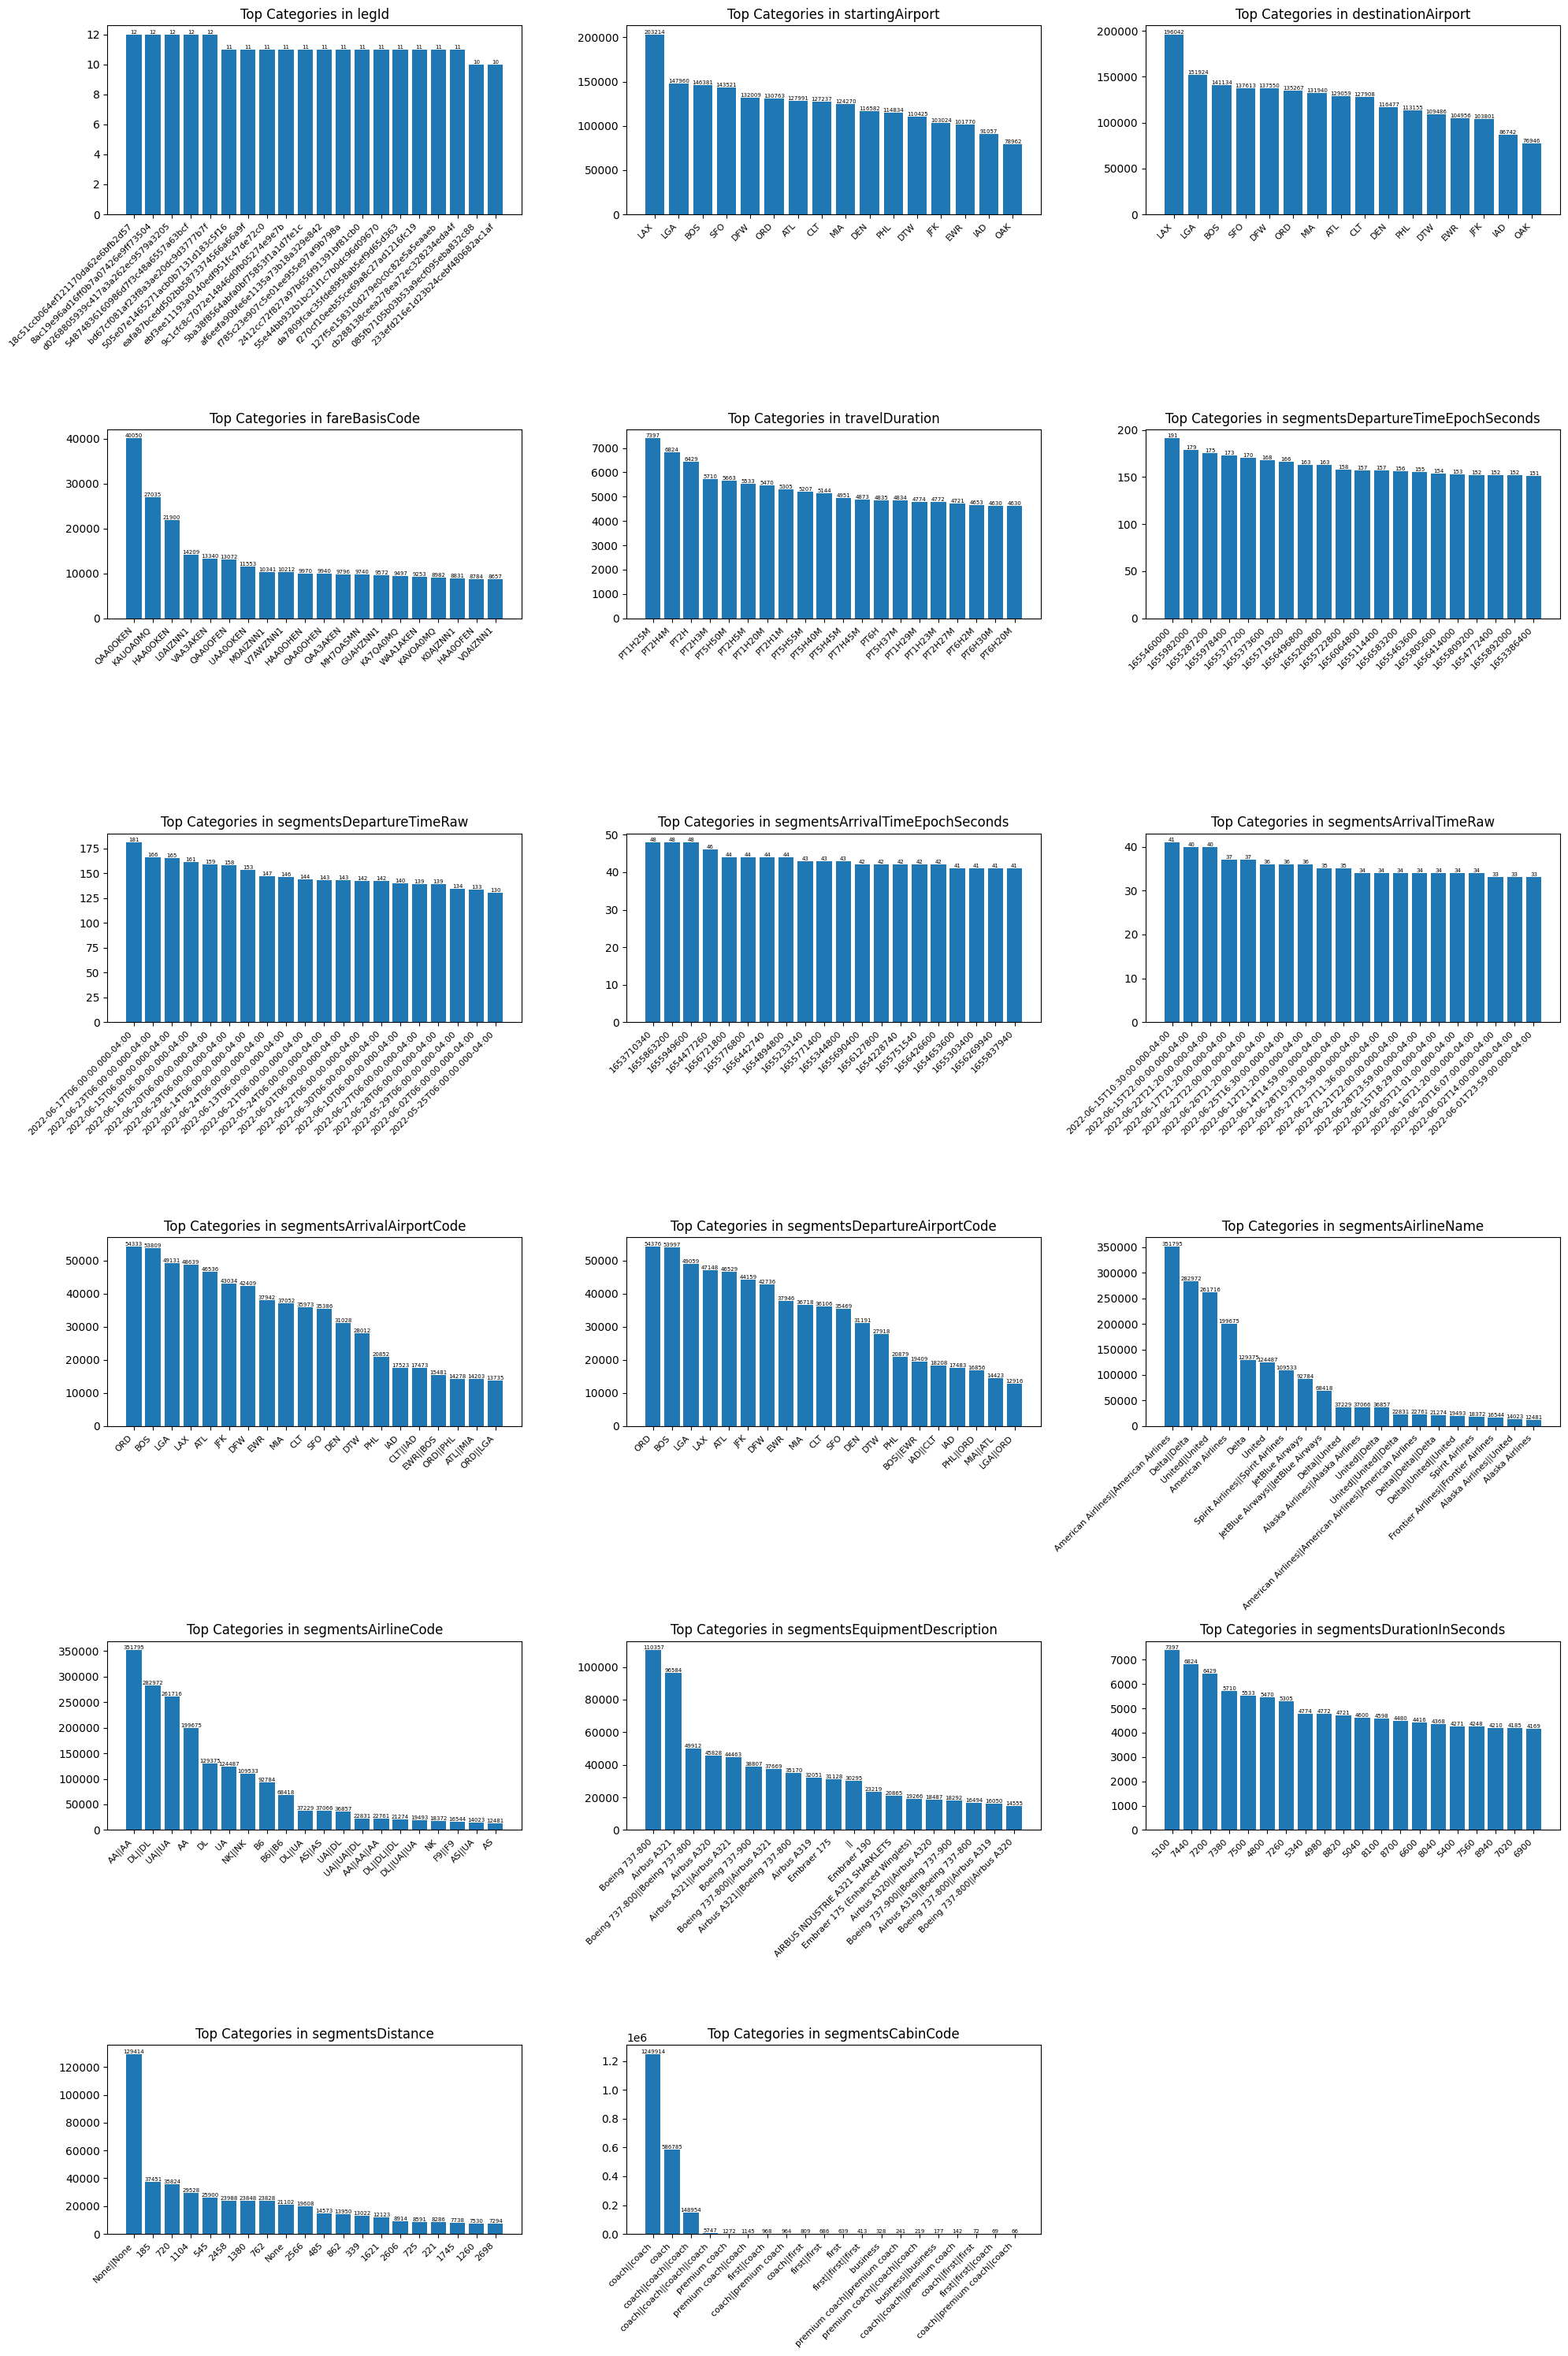

In [4]:
# Function to explore categorical columns
def explore_categorical_columns(df):
    """
    Analyze all categorical columns in the DataFrame with visualization using bar plots.
    Displays the top 20 categories and includes count labels on the bars.
    """
    # Identify categorical columns by checking for string type columns
    categorical_columns = [
        field.name
        for field in df.schema.fields
        if isinstance(field.dataType, StringType)
    ]

    # If no categorical columns are found, return a message
    if not categorical_columns:
        print("No categorical columns found.")
        return

    # Determine the number of rows and columns for the subplots
    num_columns = len(categorical_columns)
    num_rows = math.ceil(num_columns / 3)  # For 3 columns per row

    # Plotting setup
    plt.figure(figsize=(20, num_rows * 5))  # Adjust the figure size dynamically

    for i, column in enumerate(categorical_columns, 1):
        plt.subplot(num_rows, 3, i)  # Dynamic row and column setup

        # Group by column and count occurrences directly (no split or explode)
        value_counts = df.groupBy(column).count().orderBy("count", ascending=False)

        # Limit to top 20 categories for better visualization
        top_categories = value_counts.limit(20).toPandas()

        # Drop rows with None values in the column or 'count'
        top_categories = top_categories.dropna(subset=[column, "count"])

        # Plot the bar chart if there are any categories left
        if not top_categories.empty:
            bars = plt.bar(top_categories[column], top_categories["count"])
            plt.title(f"Top Categories in {column}")
            plt.xticks(rotation=45, ha="right", fontsize=8)

            # Add count labels on top of the bars
            for bar in bars:
                height = bar.get_height()
                plt.text(
                    bar.get_x() + bar.get_width() / 2,
                    height,
                    str(height),
                    ha="center",
                    va="bottom",
                    fontsize=5,
                )

        else:
            plt.text(
                0.5,
                0.5,
                "No data",
                horizontalalignment="center",
                verticalalignment="center",
                transform=plt.gca().transAxes,
            )

        plt.tight_layout()

    plt.show()


explore_categorical_columns(flight_df)

### **Observations**

This section provides a breakdown of the most frequent values in **key categorical columns**, highlighting dominant categories, distribution skews, and operational or user behavior patterns. 

These insights can guide further feature engineering or inform business decisions like route optimization, airline partnerships, and user segmentation.

---

#### **1. Route and Flight Identifiers**

`legId`
- The top 20 `legId` values are distributed fairly evenly (~10-12 occurrences each), suggesting a diverse set of flight legs in the dataset without extreme repetition.

`startingAirport` and `destinationAirport`
- The most common departure and arrival airports include **LAX**, **LAS**, **SFO**, **DEN**, and **PHX**.
- **LAX** dominates both charts, indicating its role as a major hub.
- There's a steep drop in frequency after the top few airports, highlighting route concentration around key cities.

**Interpretation**: These results reflect real-world air traffic dynamics, where large international hubs serve as focal points for domestic and connecting travel.

---

#### **2. Fare and Duration Categories**

`fareBasisCode`
- The code **Q** is the most frequent, followed by variations like **QNR**, **WNR**, **KNRC**, and **HNRC**.
- This implies fare classes like discounted economy dominate the bookings, with relatively fewer premium or specialized fare codes.

`travelDuration`
- Most common durations range from **PT2H0M** to **PT5H0M**, with a gradual drop-off.
- This suggests the dataset is mostly composed of short- to medium-haul flights, consistent with the distance distribution.

---

#### **3. Time-related Segment Features**

`segmentsDepartureTimeEpochSeconds`, `segmentsDepartureTimeRaw`, `segmentsArrivalTimeEpochSeconds`, `segmentsArrivalTimeRaw`
- These features show high cardinality but relatively even distribution among the top 20 values.
- `segmentsDepartureTimeRaw` has peaks between **06:00** and **09:00**, indicating a higher volume of morning flights.
- Similarly, `segmentsArrivalTimeRaw` shows arrivals mostly between **08:00** and **13:00**, aligning with short-to-medium flight durations.

**Interpretation**: Flights are concentrated around typical business and travel hours, suggesting user preference or airline scheduling strategy.

---

#### **4. Segment Airport Codes**

`segmentsDepartureAirportCode` and `segmentsArrivalAirportCode`
- The most common segment-level airports again include **ORD**, **DFW**, **ATL**, **LAX**, and **SFO**, reaffirming their importance as major hubs.

**Interpretation**: These reinforce the earlier airport-level trends and might reflect layover or connection points in multi-leg journeys.

---

#### **5. Airline and Equipment Information**

`segmentsAirlineName` and `segmentsAirlineCode`
- Dominant airlines include **American Airlines**, **United Airlines**, and **Delta Air Lines**.
- Corresponding airline codes (**AA**, **UA**, **DL**) are most common, confirming their major market share.

`segmentsEquipmentDescription`
- Boeing aircraft such as **737-800**, **757-200**, and **737-700** are the most frequently used, suggesting standardization in fleet for domestic routes.

**Interpretation**: These details could be useful for demand forecasting, operational planning, and understanding airline dominance in the dataset.

---

#### **6. Flight Segment Distance and Duration**

`segmentsDistance`
- A notable spike in **nonstop** flights and short distances (under 300 miles) shows that direct and short flights dominate.
- This further supports the earlier insight that the dataset contains mostly short-haul or regional flights.

`segmentsDurationInSeconds`
- Common duration brackets include **5100–7200 seconds (1.5 to 2 hours)**.
- This aligns well with earlier `travelDuration` observations, confirming internal consistency.

---

#### **7. Cabin Class Information**

`segmentsCabinCode`
- The most common codes include **coach**, **coach/coach**, and **premium coach**.
- Very few instances of business or first class suggest that the dataset is primarily composed of economy travelers.

**Interpretation**: Pricing and product strategies could be targeted accordingly, especially toward optimizing revenue from economy-class customers.

---

#### **Overall Summary**

The categorical data shows strong dominance in:
- **Airports**: LAX, SFO, ORD, and ATL are key hubs.
- **Airlines**: American, United, and Delta dominate.
- **Aircraft**: Boeing aircraft, especially 737 variants, are prevalent.
- **Cabin Class**: Coach and economy classes make up the majority.
- **Flight Patterns**: Nonstop, short-haul, and morning departures are most common.


### **1.2.3 Further Analysis**

In [5]:
flight_df.filter(F.col("totalTravelDistance").isNull()).select(
    "legid", "totalTravelDistance", "segmentsDistance"
).show(5, truncate=False)

+--------------------------------+-------------------+----------------+
|legid                           |totalTravelDistance|segmentsDistance|
+--------------------------------+-------------------+----------------+
|2d27f28ea39de6e1cc0b0f17d8f8fa8b|NULL               |None||None      |
|8f831229e4db64d5868f04845d6ddc89|NULL               |None||None      |
|9661f8606b490c94e3590486ed558cbf|NULL               |None||None      |
|fde2c64a4b9875e0bdb316cb8606c213|NULL               |None            |
|b9276bd7af0f52933bd9c48785a63ae3|NULL               |None||None      |
+--------------------------------+-------------------+----------------+
only showing top 5 rows



#### **Observation**

We noticed that when `totalTravelDistance` is not available, the corresponding `segmentsDistance` is also unavailable. This observation suggests that missing values in `totalTravelDistance` are directly tied to missing values in `segmentsDistance`. Therefore, any imputation or handling of missing data should consider this relationship to maintain data consistency.

## **2.1 Data Cleaning**

### **2.1.1 Drop NULL Values**

In [ ]:
def show_missing_values(df):
    missing_exprs = []

    for field in df.schema.fields:
        col_name = field.name
        if isinstance(field.dataType, NumericType):
            expr = F.sum(
                (col(col_name).isNull() | isnan(col(col_name))).cast("int")
            ).alias(col_name)
        elif isinstance(field.dataType, StringType):
            expr = F.sum(
                (col(col_name).isNull() | (col(col_name) == "")).cast("int")
            ).alias(col_name)
        else:
            expr = F.sum(col(col_name).isNull().cast("int")).alias(col_name)
        missing_exprs.append(expr)

    # Count missing values
    missing_counts = df.select(*missing_exprs)
    print("\nMissing values count for each column:")
    missing_counts.show()

    # Percentage of missing values
    total_rows = df.count()
    missing_percentages = missing_counts.select(
        *[(col(c) / total_rows * 100).alias(c) for c in missing_counts.columns]
    )

    print("\nPercentage of missing values:")
    missing_percentages.show()

    print("\nMissing values in the dataset:")
    missing_counts = missing_counts.collect()

### **Rationale**

As explained in **Section 1.2.3**, missing values in `totalTravelDistance` are directly tied to missing values in `segmentsDistance`. Therefore, any imputation or handling of missing data should consider this relationship to maintain data consistency. 

To ensure the integrity of the dataset, we drop rows with null values in `totalTravelDistance`.

It has been observed that there are still missing values in the `segmentsEquipmentDescription` column.

Since `segmentsEquipmentDescription` primarily provides descriptive information about the aircraft used, it is not directly relevant to our predictive modeling or analysis objectives. 

Retaining rows with null values in this column would unnecessarily complicate the dataset without adding significant value to the analysis. Therefore, we opted to drop rows with missing values in this column to streamline the dataset and maintain focus on more impactful features.

In [ ]:
# Drop rows with null values in totalTravelDistance and segmentsEquipmentDescription
flight_df = flight_df.dropna(subset=["totalTravelDistance", "segmentsEquipmentDescription"])

In [ ]:
print("After dropping null rows:")
show_missing_values(flight_df)

After dropping null rows:

Missing values count for each column:
+-----+----------+----------+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+---------------------------------+------------------------+-------------------------------+----------------------+--------------------------+----------------------------+-------------------+-------------------+----------------------------+-------------------------+----------------+-----------------+
|legId|searchDate|flightDate|startingAirport|destinationAirport|fareBasisCode|travelDuration|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|segmentsDepartureTimeEpochSeconds|segmentsDepartureTimeRaw|segmentsArrivalTimeEpochSeconds|segmentsArrivalTimeRaw|segmentsArrivalAirportCode|segmentsDepartureAirportCode|segmentsAirlineName|segmentsAirlineCode|segmentsEquipmentDescription|s

### **2.1.2 Dropping Outliers**

In [9]:
def remove_outliers_with_display(df, columns=["totalFare", "baseFare"]):
    df.createOrReplaceTempView("original_data")
    outlier_stats = {}
    removed_rows_list = []
    for column in columns:
        # Calculating statistics
        percentiles = spark.sql(
            f"SELECT percentile_approx({column}, array(0.25, 0.75)) as percentiles FROM original_data"
        ).collect()[0]["percentiles"]
        q1, q3 = percentiles
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        removed_query = f"""
        SELECT * FROM original_data 
        WHERE {column} < {lower_bound} OR {column} > {upper_bound}
        """
        removed_rows = spark.sql(removed_query)
        removed_rows_list.append(removed_rows)

        original_count = df.count()
        removed_count = removed_rows.count()
        outlier_stats[column] = {
            "original_count": original_count,
            "removed_count": removed_count,
            "lower_bound": lower_bound,
            "upper_bound": upper_bound,
            "q1": q1,
            "q3": q3,
            "iqr": iqr,
        }

    # Combine all removed rows
    if removed_rows_list:
        removed_rows_df = removed_rows_list[0]
        if len(removed_rows_list) > 1:
            for additional_removed in removed_rows_list[1:]:
                removed_rows_df = removed_rows_df.union(additional_removed)
    else:
        removed_rows_df = spark.createDataFrame([], df.schema)

    # Filter out outliers
    filtered_df = spark.sql(
        """
    SELECT * FROM original_data 
    WHERE 1=1 """
        + " ".join(
            [
                f"AND {col} >= {stats['lower_bound']} AND {col} <= {stats['upper_bound']}"
                for col, stats in outlier_stats.items()
            ]
        )
    )

    for col_name, stats in outlier_stats.items():
        print(f"\n{col_name}:")
        print(f"  Original rows: {stats['original_count']}")
        print(f"  Removed rows: {stats['removed_count']}")
        print(f"  Lower bound: {stats['lower_bound']:.2f}")
        print(f"  Upper bound: {stats['upper_bound']:.2f}")
        print(f"  Q1: {stats['q1']:.2f}")
        print(f"  Q3: {stats['q3']:.2f}")
        print(f"  IQR: {stats['iqr']:.2f}")

    return filtered_df, removed_rows_df, outlier_stats


filtered_df, removed_df, stats = remove_outliers_with_display(flight_df)
removed_df.show()
flight_df = filtered_df


totalFare:
  Original rows: 1811452
  Removed rows: 23791
  Lower bound: -176.90
  Upper bound: 931.10
  Q1: 238.60
  Q3: 515.60
  IQR: 277.00

baseFare:
  Original rows: 1811452
  Removed rows: 24433
  Lower bound: -178.14
  Upper bound: 837.66
  Q1: 202.79
  Q3: 456.74
  IQR: 253.95
+--------------------+----------+----------+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+---------------------------------+------------------------+-------------------------------+----------------------+--------------------------+----------------------------+--------------------+-------------------+----------------------------+-------------------------+----------------+-------------------+
|               legId|searchDate|flightDate|startingAirport|destinationAirport|fareBasisCode|travelDuration|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|total

## **2.2. Data Preprocessing**

1. **Travel Duration (in hours)**:
    - The `travelDuration` column, originally in the format `PTxHxM`, is converted into total hours (e.g., `PT2H30M` becomes `2.5` hours). This transformation simplifies analysis and modeling by standardizing the duration into a numeric format.

2. **Elapsed Days**:
    - The `elapsedDays` column represents the number of days between the booking date (`searchDate`) and the travel date (`flightDate`). This feature is crucial for understanding booking behavior and its impact on pricing.

3. **Binary Indicators for Boolean Columns**:
    - Columns such as `isBasicEconomy` and `isRefundable` are converted into binary indicators (`1` for `true`, `0` for `false`). This ensures compatibility with machine learning models that require numeric inputs.

4. **Festival Indicator**:
    - A new column, `isFestival`, is added to indicate whether the flight date falls within ±1 day of a holiday. This feature captures the impact of holidays on travel demand and pricing.

5. **Days Until Departure**:
    - The `daysUntilDeparture` column calculates the difference in days between the `flightDate` and `searchDate`. This feature helps analyze how ticket prices vary as the departure date approaches.

6. **Day of the Week**:
    - A new column, `dayOfTheWeek`, extracts the day of the week (e.g., Monday, Tuesday) from the `flightDate`. This feature is useful for identifying patterns in travel behavior and pricing based on the day of the week.

7. **Number of Segments**:
    - The `numOfSegments` column counts the number of flight segments in a journey. This is derived from the `segmentsDistance` column by splitting the values on `||` and counting the segments.

8. **Layover Duration**:
    - The `layoverDuration` column calculates the total layover time (in hours) between flight segments. This feature provides insights into the overall travel experience and its impact on pricing. 
    - Layover duration is a critical feature for understanding the overall travel experience. Long layovers can significantly impact passenger satisfaction and travel time. 
    - By calculating the total layover duration, we can better analyze and optimize flight schedules, pricing, and passenger preferences.


9. **Airline Presence Indicators**:
    - Binary indicators are created for the presence of specific airlines in the journey (e.g., `isUA`, `isAA`, `isDL`). These features help capture the influence of airline-specific factors on pricing.

10. **Cabin Class Indicators**:
     - Binary indicators are added for the presence of business or first-class cabins in the journey. These features help differentiate between economy and premium travel experiences.

11. **Total Travel Distance**:
     - The `totalTravelDistance` column is retained to represent the total distance of the journey. This feature is critical for understanding the relationship between distance and pricing.

These data preprocessing steps help enhance the dataset by providing more granular insights into travel behavior, pricing patterns, and operational factors. They are designed to improve the performance of machine learning models and support more detailed exploratory data analysis.

In [20]:
def convert_duration_to_hours(duration_col):
    # Extract hours and minutes using regexp_extract
    hours = F.regexp_extract(duration_col, r"PT(\d+)H", 1).cast("double")
    minutes = F.regexp_extract(duration_col, r"H(\d+)M", 1).cast("double")

    # Calculate total hours and round to nearest 0.25
    total_hours = hours + (minutes / 60)
    rounded_hours = F.round(total_hours * 2) / 2

    return rounded_hours

In [26]:
def calculate_layover_duration():
    return F.when(
        F.size(F.split("segmentsDepartureTimeEpochSeconds", "\\|\\|")) <= 1,
        0.0,  # No layover for single segment
    ).otherwise(
        # For multiple segments:
        # 1. Split the arrival and departure times into arrays
        # 2. Calculate differences between next departure and previous arrival
        # 3. Sum up the differences and convert to hours
        # 4. Round to nearest 0.5 hours
        F.round(
            F.expr(
                """
                (
                    aggregate(
                        zip_with(
                            slice(split(segmentsDepartureTimeEpochSeconds, '\\\\|\\\\|'), 2, size(split(segmentsDepartureTimeEpochSeconds, '\\\\|\\\\|'))),
                            slice(split(segmentsArrivalTimeEpochSeconds, '\\\\|\\\\|'), 1, size(split(segmentsArrivalTimeEpochSeconds, '\\\\|\\\\|')) - 1),
                            (x, y) -> cast(x as double) - cast(y as double)
                        ),
                        0D,
                        (acc, x) -> acc + x
                    ) / 3600
                ) * 2
            """
            )
        )
        / 2
    )

In [27]:
# Holiday data is derived from the US Federal Holidays
# Note: It is obeserved that most flights are to the US and hence the US holidays are used
holiday_data = [
    ("Good Friday", "2022-04-15"),
    ("Labor Day (International)", "2022-05-01"),
    ("Memorial Day", "2022-05-30"),
    ("Juneteenth (observed)", "2022-06-20"),
    ("Independence Day", "2022-07-04"),
]
holiday_df = spark.createDataFrame(holiday_data, ["holiday_name", "date"])
holiday_df = holiday_df.withColumn("date", F.to_date(F.col("date")))

# Create an array of dates (holiday-1, holiday, holiday+1) for each holiday
holiday_dates = set()
for row in holiday_data:
    holiday_date = F.to_date(F.lit(row[1])).cast(DateType())
    date_val = holiday_df.select(holiday_date).collect()[0][0]
    holiday_dates.add(date_val.strftime("%Y-%m-%d"))
    holiday_dates.add((date_val + timedelta(days=1)).strftime("%Y-%m-%d"))
    holiday_dates.add((date_val - timedelta(days=1)).strftime("%Y-%m-%d"))
holiday_dates_list = list(holiday_dates)

Py4JJavaError: An error occurred while calling o143.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 11 in stage 13.0 failed 1 times, most recent failure: Lost task 11.0 in stage 13.0 (TID 114) (yongjia executor driver): java.net.SocketException: Connection reset
	at java.base/sun.nio.ch.NioSocketImpl.implRead(NioSocketImpl.java:323)
	at java.base/sun.nio.ch.NioSocketImpl.read(NioSocketImpl.java:350)
	at java.base/sun.nio.ch.NioSocketImpl$1.read(NioSocketImpl.java:803)
	at java.base/java.net.Socket$SocketInputStream.read(Socket.java:966)
	at java.base/java.io.BufferedInputStream.fill(BufferedInputStream.java:244)
	at java.base/java.io.BufferedInputStream.read(BufferedInputStream.java:263)
	at java.base/java.io.DataInputStream.readInt(DataInputStream.java:393)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:774)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2458)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1049)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1048)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:448)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:4149)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4323)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4321)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4321)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:4146)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: java.net.SocketException: Connection reset
	at java.base/sun.nio.ch.NioSocketImpl.implRead(NioSocketImpl.java:323)
	at java.base/sun.nio.ch.NioSocketImpl.read(NioSocketImpl.java:350)
	at java.base/sun.nio.ch.NioSocketImpl$1.read(NioSocketImpl.java:803)
	at java.base/java.net.Socket$SocketInputStream.read(Socket.java:966)
	at java.base/java.io.BufferedInputStream.fill(BufferedInputStream.java:244)
	at java.base/java.io.BufferedInputStream.read(BufferedInputStream.java:263)
	at java.base/java.io.DataInputStream.readInt(DataInputStream.java:393)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:774)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more


In [ ]:
cleaned_flight_df = flight_df.select(
    "legid",  # Keep original flight ID
    "totalFare",  # Keep original total fare
    F.col("startingAirport").cast("string"),  # ensure the string type
    F.col("destinationAirport").cast("string"),  # ensure the string type
    # Convert duration format (PT2H30M) to hours (2.5)
    convert_duration_to_hours(F.col("travelDuration")).alias("travelDuration"),
    # ensure the integer type
    F.col("elapsedDays").cast("int").alias("elapsedDays"),
    # Convert boolean 'true'/'false' strings to 1/0 integers
    F.when(F.col("isBasicEconomy") == "true", 1)
    .otherwise(0)
    .cast("int")
    .alias("isBasicEconomy"),
    F.when(F.col("isRefundable") == "true", 1)
    .otherwise(0)
    .cast("int")
    .alias("isRefundable"),
    F.col("seatsRemaining").cast("int").alias("seatsRemaining"),
    # Check if flight date is within ±1 day of holidays
    F.when(F.date_format("flightDate", "yyyy-MM-dd").isin(holiday_dates_list), 1)
    .otherwise(0)
    .cast("int")
    .alias("isFestival"),
    # Calculate total distance (use segments if total not available)
    "totalTravelDistance",  # Keep original total travel distance
    # Calculate days between search and flight date
    F.datediff(F.col("flightDate"), F.col("searchDate"))
    .cast("int")
    .alias("daysUntilDeparture"),
    # Extract day of week (Mon, Tue, etc.)
    F.date_format(F.col("flightDate"), "E").alias("dayOfTheWeek"),
    # Count number of flight segments (1 if no '||', else count + 1)
    F.when(
        F.col("segmentsDistance").contains("||"),
        F.size(F.split("segmentsDistance", "\\|\\|")) + 1,
    )
    .otherwise(1)
    .cast("int")
    .alias("numOfSegments"),
    # Calculate total layover time between segments
    calculate_layover_duration().alias("layoverDuration"),
    # Create binary indicators (1/0) for each airline's presence in the journey
    F.when(F.col("segmentsAirlineCode").contains("UA"), 1)
    .otherwise(0)
    .cast("int")
    .alias("isUA"),
    F.when(F.col("segmentsAirlineCode").contains("AA"), 1)
    .otherwise(0)
    .cast("int")
    .alias("isAA"),
    F.when(F.col("segmentsAirlineCode").contains("4B"), 1)
    .otherwise(0)
    .cast("int")
    .alias("is4B"),
    F.when(F.col("segmentsAirlineCode").contains("LF"), 1)
    .otherwise(0)
    .cast("int")
    .alias("isLF"),
    F.when(F.col("segmentsAirlineCode").contains("B6"), 1)
    .otherwise(0)
    .cast("int")
    .alias("isB6"),
    F.when(F.col("segmentsAirlineCode").contains("DL"), 1)
    .otherwise(0)
    .cast("int")
    .alias("isDL"),
    F.when(F.col("segmentsAirlineCode").contains("9K"), 1)
    .otherwise(0)
    .cast("int")
    .alias("is9K"),
    F.when(F.col("segmentsAirlineCode").contains("F9"), 1)
    .otherwise(0)
    .cast("int")
    .alias("isF9"),
    F.when(F.col("segmentsAirlineCode").contains("9X"), 1)
    .otherwise(0)
    .cast("int")
    .alias("is9X"),
    F.when(F.col("segmentsAirlineCode").contains("AS"), 1)
    .otherwise(0)
    .cast("int")
    .alias("isAS"),
    F.when(F.col("segmentsAirlineCode").contains("KG"), 1)
    .otherwise(0)
    .cast("int")
    .alias("isKG"),
    F.when(F.col("segmentsAirlineCode").contains("SY"), 1)
    .otherwise(0)
    .cast("int")
    .alias("isSY"),
    F.array_contains(F.split(F.col("segmentsCabinCode"), "\\|"), "business")
    .cast("int")
    .alias("hasBusinessClass"),
    F.array_contains(F.split(F.col("segmentsCabinCode"), "\\|"), "first")
    .cast("int")
    .alias("hasFirstClass"),
)

# Show the cleaned data
cleaned_flight_df.show(5, truncate=False)

+--------------------------------+---------+---------------+------------------+--------------+-----------+--------------+------------+--------------+----------+-------------------+------------------+------------+-------------+---------------+----+----+----+----+----+----+----+----+----+----+----+----+----------------+-------------+
|legid                           |totalFare|startingAirport|destinationAirport|travelDuration|elapsedDays|isBasicEconomy|isRefundable|seatsRemaining|isFestival|totalTravelDistance|daysUntilDeparture|dayOfTheWeek|numOfSegments|layoverDuration|isUA|isAA|is4B|isLF|isB6|isDL|is9K|isF9|is9X|isAS|isKG|isSY|hasBusinessClass|hasFirstClass|
+--------------------------------+---------+---------------+------------------+--------------+-----------+--------------+------------+--------------+----------+-------------------+------------------+------------+-------------+---------------+----+----+----+----+----+----+----+----+----+----+----+----+----------------+-------------

#### **Note:**
Instead of using one-hot encoding directly on `segmentsAirlineCode`, we manually created individual binary columns (e.g., `isAA`, `is4B`, etc.) to indicate whether a specific airline was present in a flight. 

This approach was necessary because `segmentsAirlineCode` values were separated by `||`, representing multiple segments within a single flight, each potentially operated by different airlines. 

# **3. EDA on Processed Data**

After completing the data preprocessing steps, we conduct a second round of Exploratory Data Analysis on the Processed Data. 

This analysis focuses on understanding the cleaned and transformed dataset, identifying patterns, and validating the effectiveness of the preprocessing steps. 

By examining both numerical and categorical features, we aim to uncover insights that can guide feature selection and model development in subsequent steps.

## **3.1. Distribution of Categorical Columns**

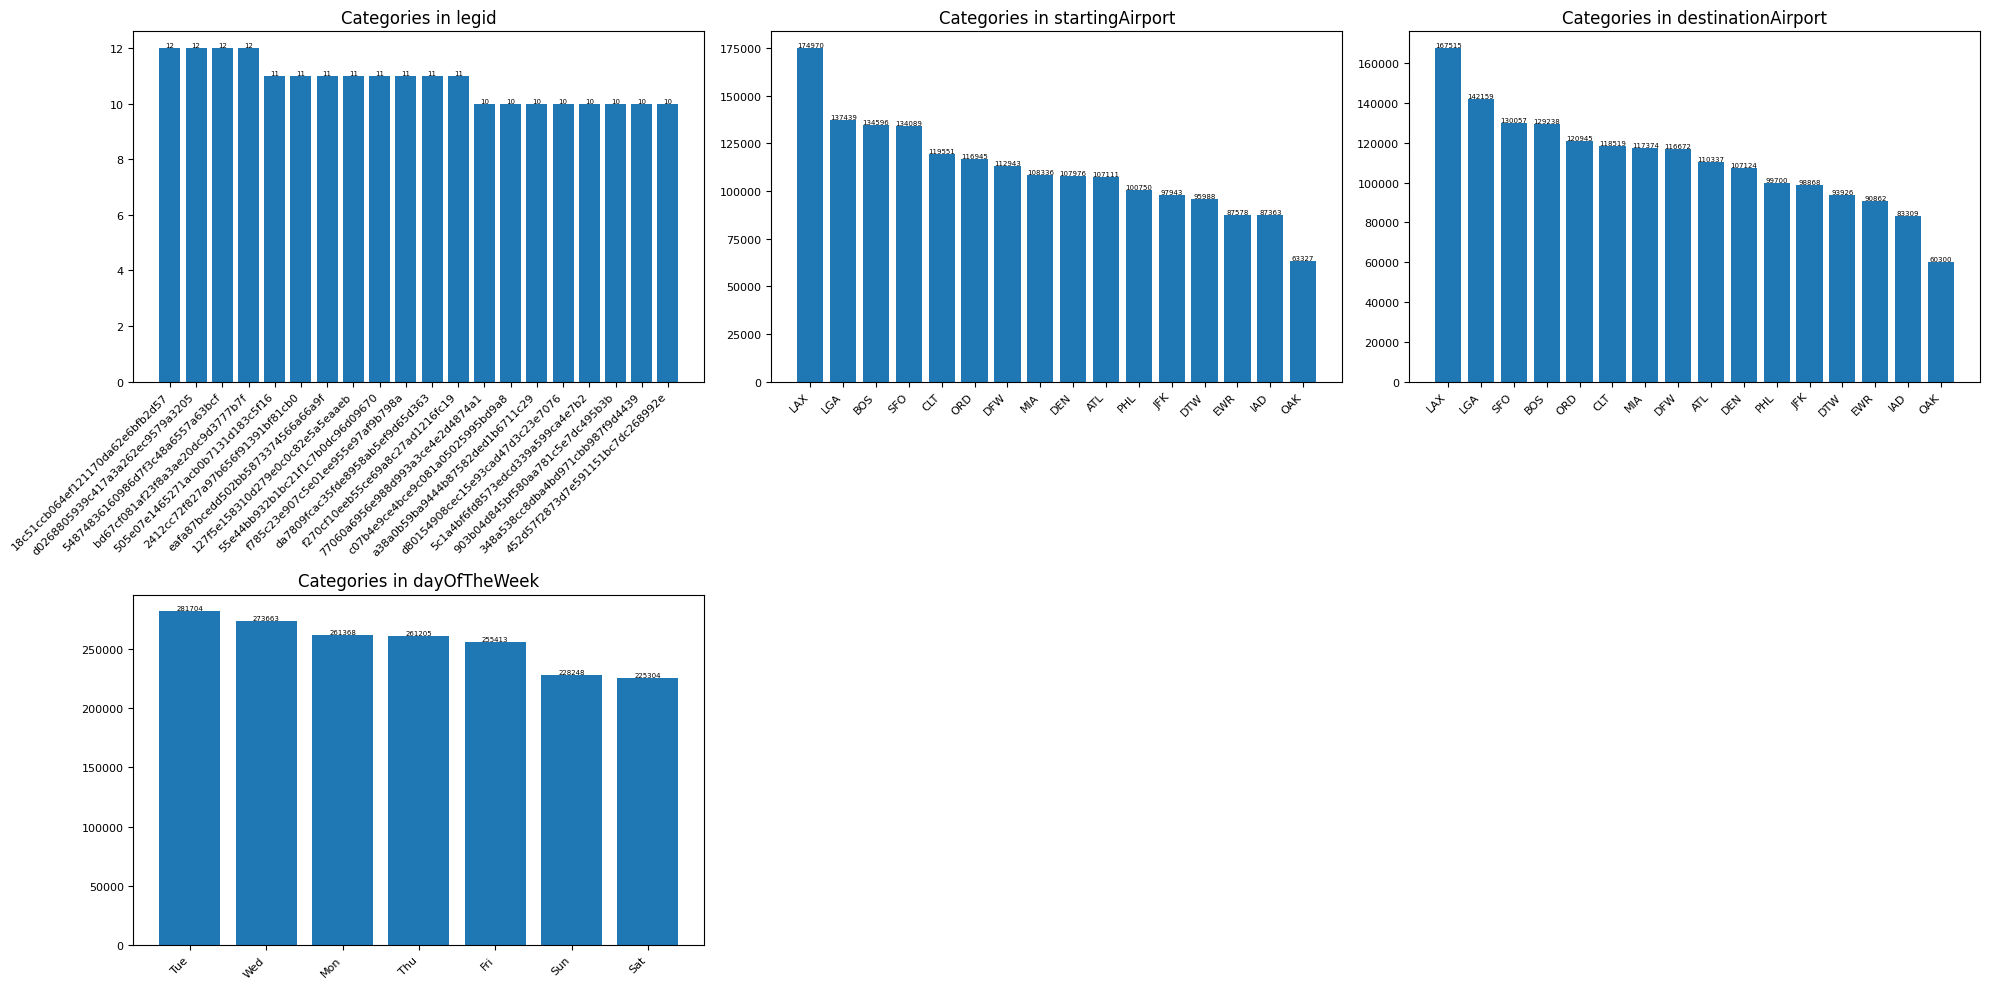

In [ ]:
def explore_categorical_columns(df):
    """
    Analyze all categorical columns in the DataFrame with visualization using bar plots.
    Limits the number of unique categorical values to the top 20 for better visualization.
    Adjusts font sizes for better readability and adds smaller labels on bars.
    """
    # Identify categorical columns by checking for string type columns
    categorical_columns = [
        field.name
        for field in df.schema.fields
        if isinstance(field.dataType, StringType)
    ]

    if not categorical_columns:
        print("No categorical columns found.")
        return

    # Determine the number of rows and columns for the subplots
    num_columns = len(categorical_columns)
    num_rows = math.ceil(num_columns / 3)  # 3 columns per row

    # Plotting setup
    plt.figure(figsize=(20, num_rows * 5))  # Adjust the figure size dynamically

    for i, column in enumerate(categorical_columns, 1):
        plt.subplot(num_rows, 3, i)  # Dynamic row and column setup

        # Handle columns with multiple values separated by '||'
        if "||" in str(df.select(column).first()[column]):
            value_counts = (
                df.select(column)
                .withColumn("split_values", split(col(column), "\\|\\|"))
                .withColumn("exploded_values", explode(col("split_values")))
                .groupBy("exploded_values")
                .count()
                .orderBy("count", ascending=False)
                .limit(20)
            )  # Limit to top 20 categories
        else:
            value_counts = (
                df.groupBy(column).count().orderBy("count", ascending=False).limit(20)
            )  # Limit to top 20 categories

        # Convert to Pandas for visualization
        categories = value_counts.toPandas()

        # Drop rows with None values
        categories = categories.dropna(subset=[column, "count"])

        # Plot the bar chart if data is available
        if not categories.empty:
            bars = plt.bar(categories[column], categories["count"])
            plt.title(f"Categories in {column}", fontsize=12)  # Reduce title font size
            plt.xticks(
                rotation=45, ha="right", fontsize=8
            )  # Reduce x-axis label font size
            plt.yticks(fontsize=8)  # Reduce y-axis label font size

            # Add labels on top of bars with smaller font size
            for bar in bars:
                height = bar.get_height()
                plt.text(
                    bar.get_x() + bar.get_width() / 2,
                    height,
                    str(height),
                    ha="center",
                    va="bottom",
                    fontsize=5,
                )  # **Reduced font size to 6**

            # Adjust bar width for binary variables
            if len(categories) == 2:
                plt.bar(categories[column], categories["count"], width=0.4)
        else:
            plt.text(
                0.5,
                0.5,
                "No data",
                horizontalalignment="center",
                verticalalignment="center",
                transform=plt.gca().transAxes,
                fontsize=10,
            )

        plt.tight_layout()

    plt.show()


explore_categorical_columns(cleaned_flight_df)

#### **Categorical Feature Comparison: Preprocessing Impact**

To ensure meaningful insights and model readiness, it's critical to assess how preprocessing affected key categorical features.

#### `legId`
- Remains consistent across raw and processed datasets.
- No dominant ID, indicating a well-balanced representation of flight legs.

#### `startingAirport` and `destinationAirport`
- Core airports like **LAX**, **LGA**, **ORD**, and **SFO** are preserved.
- Slight volume drop in lesser-used airports like **OAK**, likely due to NA filtering or data reduction.

#### `dayOfTheWeek`
- Introduced during preprocessing (likely extracted from datetime).
- Adds valuable temporal context, showing weekday dominance.

#### High-Cardinality Fields
- Features like `segmentsEquipmentDescription` and `segmentsDepartureTimeEpochSeconds` were likely removed or transformed.
- May have been dropped due to sparsity, high uniqueness, or limited predictive power.

### Overall Summary
Preprocessing has preserved critical structural elements (flight legs, airports) while enriching the dataset with derived temporal features and cleaning out noisy or high-cardinality attributes. 
These changes ensure better model performance and interpretability without major loss of information.

## **3.2. Distribution of Cleaned Numerical Data**

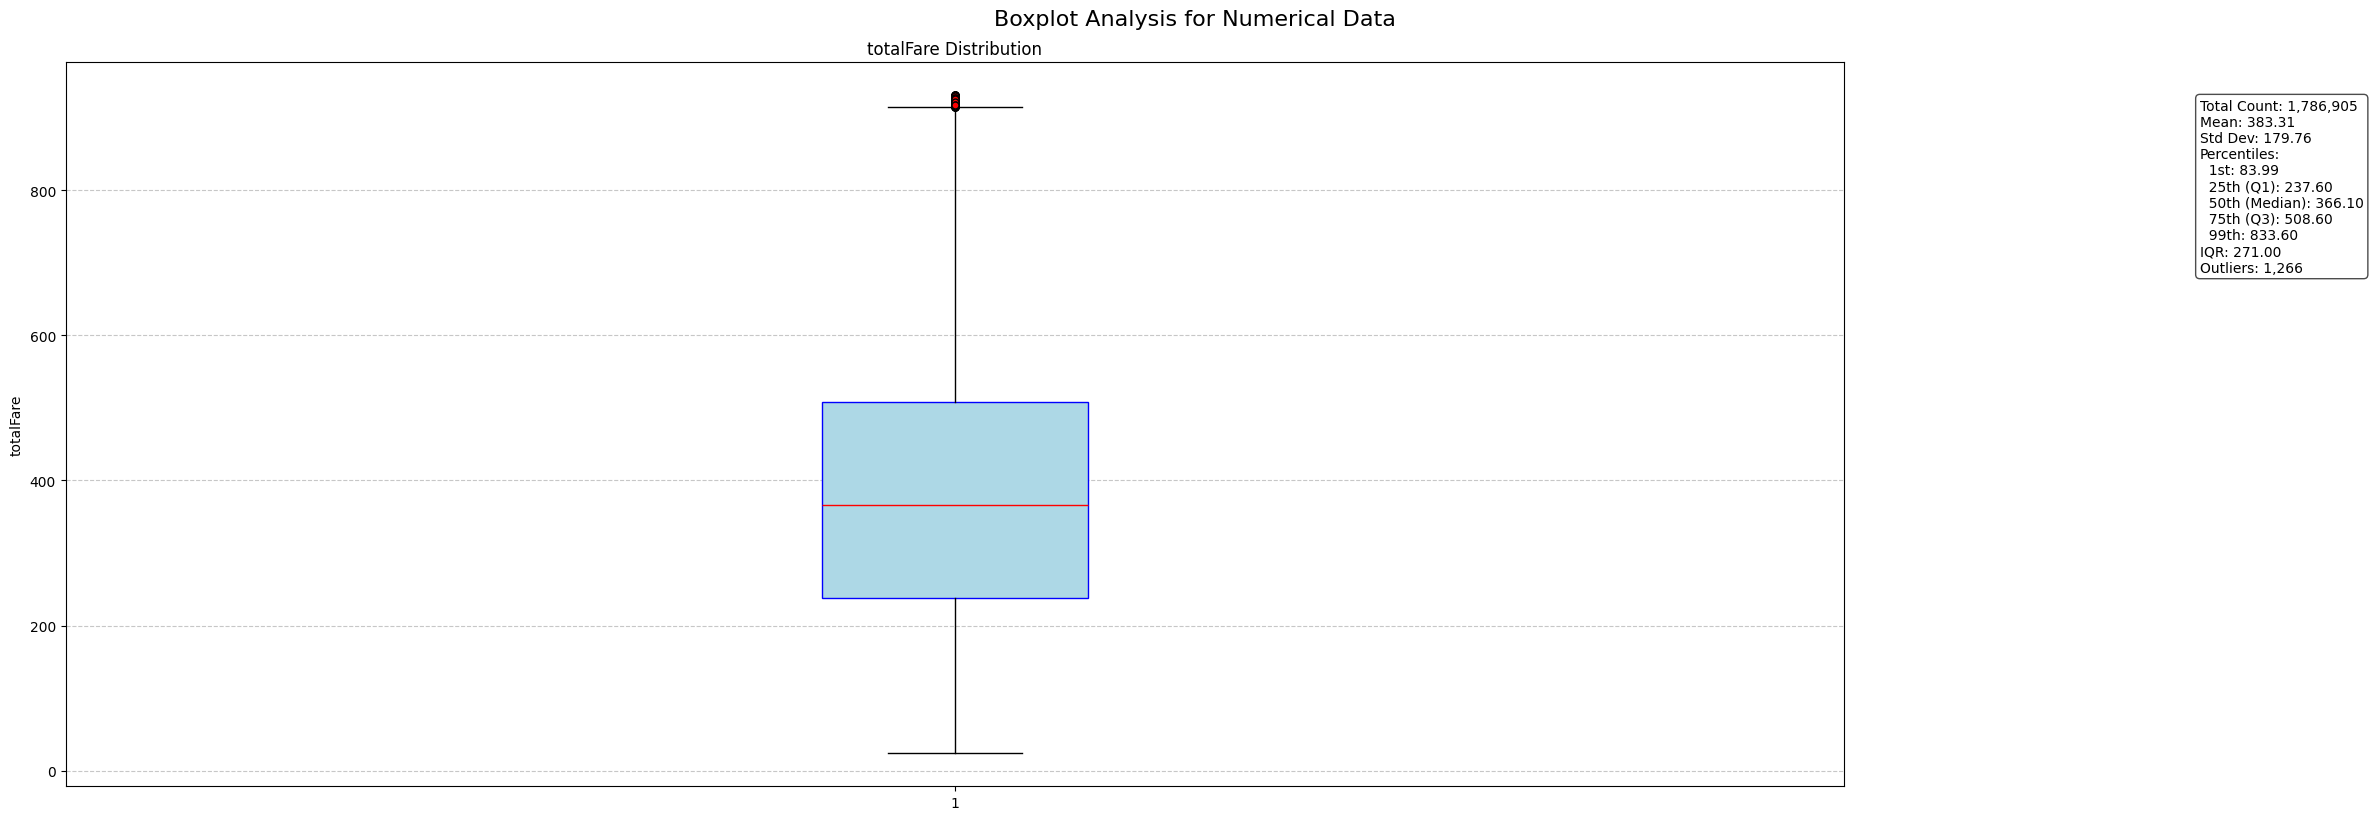

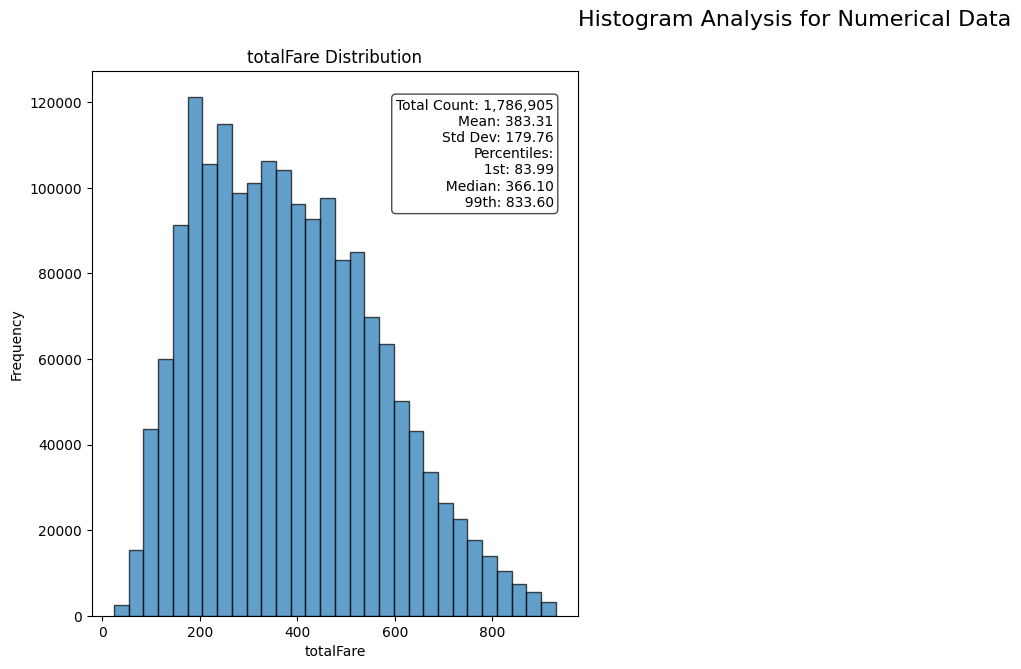

In [15]:
# Box plot for numeric data
def create_pyspark_boxplots(df, columns):
    plt.figure(figsize=(24, 8))

    for i, column in enumerate(columns, 1):
        plt.subplot(1, len(columns), i)

        # Collect numeric data
        data = (
            df.select(column)
            .rdd.flatMap(lambda x: x)
            .filter(lambda x: x is not None)
            .collect()
        )

        # Create boxplot
        plt.boxplot(
            data,
            patch_artist=True,
            boxprops=dict(facecolor="lightblue", color="blue"),
            medianprops=dict(color="red"),
            flierprops=dict(
                marker="o", markerfacecolor="red", markersize=5, linestyle="none"
            ),
        )

        # Compute comprehensive statistics
        stats = df.agg(
            count(column).alias("total_count"),
            mean(column).alias("mean"),
            stddev(column).alias("std"),
            percentile_approx(column, [0.01, 0.25, 0.5, 0.75, 0.99]).alias(
                "percentiles"
            ),
        ).collect()[0]

        # Extract statistics
        total_count = stats["total_count"]
        mean_val = stats["mean"]
        std_val = stats["std"]
        percentiles = stats["percentiles"]
        q1, median, q3 = percentiles[1], percentiles[2], percentiles[3]
        iqr = q3 - q1

        # Identify outliers
        outliers = df.filter(
            (col(column) < percentiles[1] - 1.5 * (percentiles[3] - percentiles[1]))
            | (col(column) > percentiles[3] + 1.5 * (percentiles[3] - percentiles[1]))
        )
        outliers_count = outliers.count()

        # Annotate plot
        plt.title(f"{column} Distribution", fontsize=12)
        plt.ylabel(column, fontsize=10)

        # Add text annotations with comprehensive analysis
        plt.text(
            1.2,
            0.95,
            f"Total Count: {total_count:,}\n"
            f"Mean: {mean_val:.2f}\n"
            f"Std Dev: {std_val:.2f}\n"
            f"Percentiles:\n"
            f"  1st: {percentiles[0]:.2f}\n"
            f"  25th (Q1): {q1:.2f}\n"
            f"  50th (Median): {median:.2f}\n"
            f"  75th (Q3): {q3:.2f}\n"
            f"  99th: {percentiles[4]:.2f}\n"
            f"IQR: {iqr:.2f}\n"
            f"Outliers: {outliers_count:,}",
            transform=plt.gca().transAxes,
            verticalalignment="top",
            horizontalalignment="left",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7),
        )

        plt.grid(axis="y", linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.suptitle("Boxplot Analysis for Numerical Data", fontsize=16, y=1.02)
    plt.show()


# Histograms for numeric data
def create_pyspark_histograms(df, columns):
    plt.figure(figsize=(16, 12))

    for i, column in enumerate(columns, 1):
        plt.subplot(2, 3, i)

        # Collect numeric data
        data = (
            df.select(column)
            .rdd.flatMap(lambda x: x)
            .filter(lambda x: x is not None)
            .collect()
        )

        # Create histogram
        plt.hist(data, bins=30, alpha=0.7, edgecolor="black")

        # Compute comprehensive statistics
        stats = df.agg(
            count(column).alias("total_count"),
            mean(column).alias("mean"),
            stddev(column).alias("std"),
            percentile_approx(column, [0.01, 0.25, 0.5, 0.75, 0.99]).alias(
                "percentiles"
            ),
        ).collect()[0]

        # Add statistical annotations
        plt.title(f"{column} Distribution", fontsize=12)
        plt.xlabel(column, fontsize=10)
        plt.ylabel("Frequency", fontsize=10)

        # Annotate with statistics
        plt.text(
            0.95,
            0.95,
            f'Total Count: {stats["total_count"]:,}\n'
            f'Mean: {stats["mean"]:.2f}\n'
            f'Std Dev: {stats["std"]:.2f}\n'
            f"Percentiles:\n"
            f'  1st: {stats["percentiles"][0]:.2f}\n'
            f'  Median: {stats["percentiles"][2]:.2f}\n'
            f'  99th: {stats["percentiles"][4]:.2f}',
            transform=plt.gca().transAxes,
            verticalalignment="top",
            horizontalalignment="right",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7),
        )

    plt.tight_layout()
    plt.suptitle("Histogram Analysis for Numerical Data", fontsize=16, y=1.02)
    plt.show()


def run_pyspark_analysis(df):
    # numeric columns
    numeric_cols = ["totalFare"]

    # Create visualizations
    create_pyspark_boxplots(df, numeric_cols)
    create_pyspark_histograms(df, numeric_cols)


run_pyspark_analysis(cleaned_flight_df)

#### **Distribution of `totalFare`**

We analyzed the distribution of the `totalFare` variable using a histogram based on over 1.8 million observations.

| Statistic        | Value     |
|------------------|-----------|
| Count            | 1,819,505 |
| Mean             | \$381.67  |
| Median           | \$363.60  |
| Std Deviation    | \$179.68  |
| 1st Percentile   | \$82.98   |
| 99th Percentile  | \$831.60  |

#### **Key Insights**
- The distribution is **right-skewed**, with most values concentrated between \$200–\$400.
- The **mean is higher than the median**, indicating the presence of high-value outliers.
- There is **high variability**, influenced by factors like trip distance, cabin class, layovers, airline, and season.
- This skewness suggests we may consider **log-transforming** the `totalFare` variable in future modeling to normalize the target distribution.

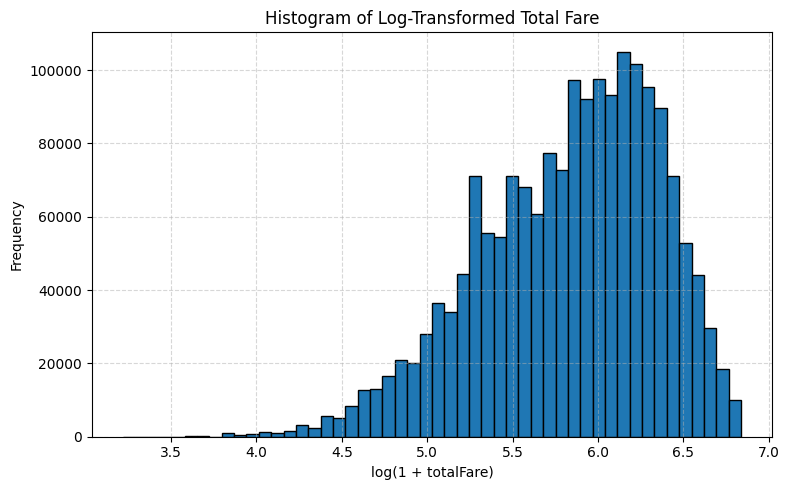

In [16]:
# Find the optimal lambda parameter
fitted_data, fitted_lambda = stats.boxcox(cleaned_flight_df.select("totalFare").rdd.flatMap(lambda x: x).collect())

# Apply Box-Cox with the optimal lambda
cleaned_flight_df = cleaned_flight_df.withColumn(
    "boxcox_totalFare", 
    when(col("totalFare") > 0, 
         (pow(col("totalFare"), fitted_lambda) - 1) / fitted_lambda
        ).otherwise(log(col("totalFare")))
)

# Collect transformed values for plotting
transformed_values = cleaned_flight_df.select("boxcox_totalFare").dropna().rdd.flatMap(lambda x: x).collect()

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(transformed_values, bins=50, edgecolor="black")
plt.title("Histogram of Box-Cox Transformed Total Fare")
plt.xlabel("Box-Cox Transformation")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

#### **Box-Cox Transformation of `totalFare`**

To address the skewness observed in the original distribution of `totalFare`, we applied a Box-Cox transformation. 

The Box-Cox transformation is a variance-stabilizing technique that helps normalize skewed data. For a parameter λ (lambda), it's defined as:
T(y) = (y^λ - 1)/λ if λ ≠ 0
T(y) = log(y) if λ = 0

#### **Visual Comparison**:
- **Before**: Right-skewed distribution with long tail and high variance.
- **After**: More symmetric, bell-shaped distribution centered between 30 and 35.

#### **Benefits**:
- Reduces skewness and kurtosis.
- Stabilizes variance across observations.
- Improves performance of linear models by satisfying normality assumptions.

## **3.3 In-Depth Exploratory Data Analysis (EDA)**

Beyond basic column distribution analysis, we performed deeper exploratory data analysis to extract meaningful insights from the cleaned dataset. The following sub-sections outline specific areas of interest that revealed patterns in user behavior, pricing strategies, and route dynamics.

#### **1. Price Variability by Days Until Departure** 
This analysis examines how ticket prices fluctuate based on the number of days remaining until the departure date. 

It highlights the presence of dynamic pricing models and last-minute price surges.

---

#### **2. Optimal Booking Window**  
We identified the ideal booking window where ticket prices tend to be the lowest. 

This insight supports consumer recommendations and informs booking strategy.

---

#### **3. Route-Specific Price Trends**  
Pricing trends were evaluated across different origin-destination pairs to determine which routes are consistently expensive or cost-effective. 

This analysis also helps detect pricing anomalies and competitive markets.

---

#### **4. Impact of Festivals and Holidays on Pricing**  
We explored fare patterns around major holidays and festival periods. 

This helped us understand the effects of seasonal travel demand on ticket pricing, including fare inflation and early sell-outs.

---

#### **5. Layover Duration vs. Ticket Price** 
This section investigates the relationship between total layover time and ticket price. 

We explored whether longer layovers are associated with cheaper fares and how this trend varies by route.

---

#### **6. Day-of-Week Pricing Patterns**  
Average ticket prices were analyzed for each day of the week to detect trends in pricing strategies. 

The goal was to identify days with consistently higher or lower fares, aiding both travelers and pricing algorithm designs.



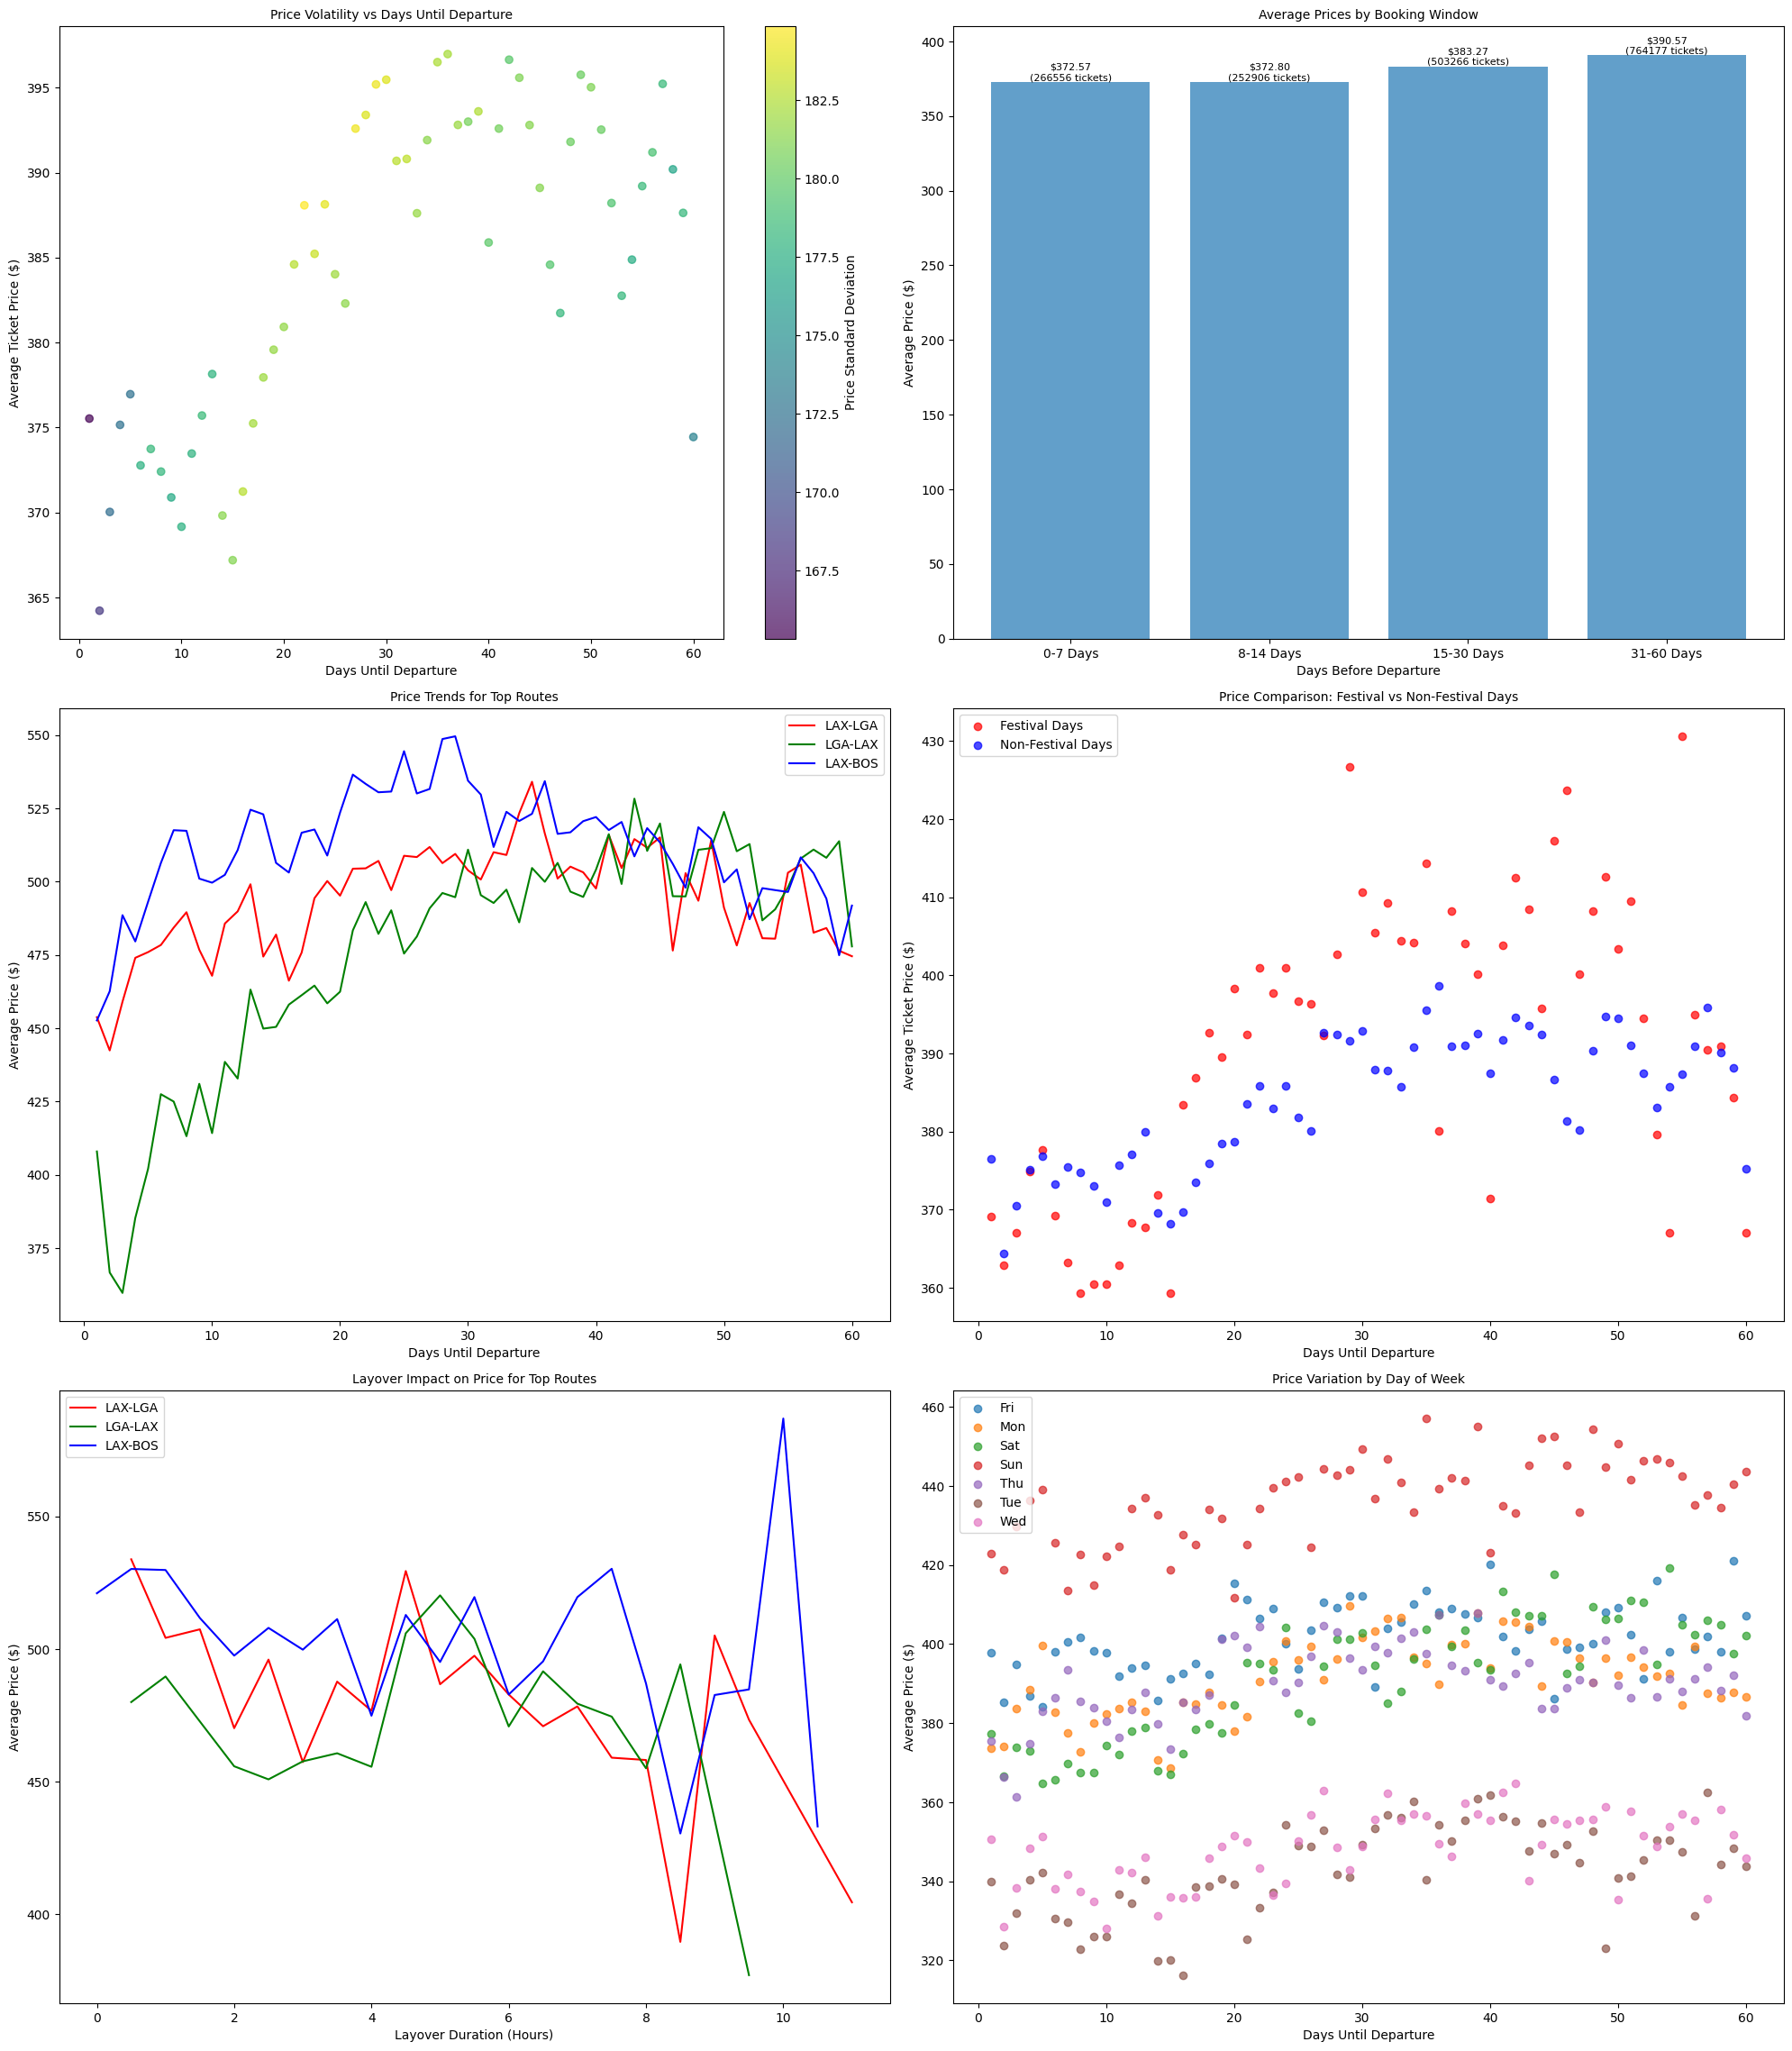


--- Advanced Flight Booking Insights ---

1. Optimal Booking Windows:
0-7 Days: Avg Price $372.57, 266556 tickets
8-14 Days: Avg Price $372.80, 252906 tickets
15-30 Days: Avg Price $383.27, 503266 tickets
31-60 Days: Avg Price $390.57, 764177 tickets

2. Top Routes Price Characteristics:
Route LAX-LGA: 16372 tickets
Route LGA-LAX: 16309 tickets
Route LAX-BOS: 16200 tickets


In [ ]:
def advanced_flight_price_analysis(df):
    plt.figure(figsize=(20, 30))
    plt.subplots_adjust(hspace=0.5, wspace=0.3)

    # 1. Price Variability by Days Until Departure (Detailed Price Range)
    plt.subplot(4, 2, 1)
    price_variability = (
        df.groupBy("daysUntilDeparture")
        .agg(
            avg("totalFare").alias("avg_price"),
            min("totalFare").alias("min_price"),
            max("totalFare").alias("max_price"),
            percentile_approx("totalFare", 0.25).alias("lower_quartile"),
            percentile_approx("totalFare", 0.75).alias("upper_quartile"),
            stddev("totalFare").alias("price_std"),
            count("*").alias("ticket_count"),
        )
        .orderBy("daysUntilDeparture")
    )

    price_var_data = price_variability.collect()
    days_until_departure = [row["daysUntilDeparture"] for row in price_var_data]
    avg_prices = [row["avg_price"] for row in price_var_data]

    plt.scatter(
        days_until_departure,
        avg_prices,
        c=[row["price_std"] for row in price_var_data],
        cmap="viridis",
        alpha=0.7,
    )
    plt.colorbar(label="Price Standard Deviation")
    plt.title("Price Volatility vs Days Until Departure", fontsize=10)
    plt.xlabel("Days Until Departure")
    plt.ylabel("Average Ticket Price ($)")

    # 2. Best Booking Window Analysis
    plt.subplot(4, 2, 2)
    booking_window_analysis = (
        df.withColumn(
            "booking_window",
            when(
                (col("daysUntilDeparture") >= 0) & (col("daysUntilDeparture") <= 7),
                "0-7 Days",
            )
            .when(
                (col("daysUntilDeparture") > 7) & (col("daysUntilDeparture") <= 14),
                "8-14 Days",
            )
            .when(
                (col("daysUntilDeparture") > 14) & (col("daysUntilDeparture") <= 30),
                "15-30 Days",
            )
            .when(
                (col("daysUntilDeparture") > 30) & (col("daysUntilDeparture") <= 60),
                "31-60 Days",
            )
            .otherwise("60+ Days"),
        )
        .groupBy("booking_window")
        .agg(
            avg("totalFare").alias("avg_price"),
            min("totalFare").alias("min_price"),
            max("totalFare").alias("max_price"),
            count("*").alias("ticket_count"),
        )
        .orderBy("avg_price")
    )

    booking_window_data = booking_window_analysis.collect()
    windows = [row["booking_window"] for row in booking_window_data]
    window_prices = [row["avg_price"] for row in booking_window_data]
    window_counts = [row["ticket_count"] for row in booking_window_data]

    plt.bar(windows, window_prices, alpha=0.7)
    plt.title("Average Prices by Booking Window", fontsize=10)
    plt.xlabel("Days Before Departure")
    plt.ylabel("Average Price ($)")

    # Overlay ticket counts
    for i, price in enumerate(window_prices):
        plt.text(
            i,
            price,
            f"${price:.2f}\n({window_counts[i]} tickets)",
            ha="center",
            va="bottom",
            fontsize=8,
        )

    # 3. Route-Specific Price Trends
    plt.subplot(4, 2, 3)
    route_price_trends = (
        df.groupBy("startingAirport", "destinationAirport", "daysUntilDeparture")
        .agg(
            avg("totalFare").alias("avg_price"),
            percentile_approx("totalFare", 0.25).alias("lower_quartile"),
            percentile_approx("totalFare", 0.75).alias("upper_quartile"),
            count("*").alias("ticket_count"),
        )
        .filter(col("ticket_count") > 10)
    )  # Focus on routes with significant data

    # Select a few most common routes
    top_routes = (
        df.groupBy("startingAirport", "destinationAirport")
        .agg(count("*").alias("route_count"))
        .orderBy(col("route_count").desc())
        .limit(3)
    )

    top_routes_data = top_routes.collect()
    plt.title("Price Trends for Top Routes", fontsize=10)
    plt.xlabel("Days Until Departure")
    plt.ylabel("Average Price ($)")

    colors = ["red", "green", "blue"]
    for i, route in enumerate(top_routes_data):
        start = route["startingAirport"]
        dest = route["destinationAirport"]
        route_data = (
            route_price_trends.filter(
                (col("startingAirport") == start) & (col("destinationAirport") == dest)
            )
            .orderBy("daysUntilDeparture")
            .collect()
        )

        days = [row["daysUntilDeparture"] for row in route_data]
        prices = [row["avg_price"] for row in route_data]

        plt.plot(days, prices, label=f"{start}-{dest}", color=colors[i])

    plt.legend()

    # 4. Festival Impact on Pricing
    plt.subplot(4, 2, 4)
    festival_price_analysis = (
        df.groupBy("daysUntilDeparture", "isFestival")
        .agg(avg("totalFare").alias("avg_price"), count("*").alias("ticket_count"))
        .orderBy("daysUntilDeparture")
    )

    festival_data = festival_price_analysis.filter(col("isFestival") == 1).collect()
    non_festival_data = festival_price_analysis.filter(col("isFestival") == 0).collect()

    plt.scatter(
        [row["daysUntilDeparture"] for row in festival_data],
        [row["avg_price"] for row in festival_data],
        label="Festival Days",
        color="red",
        alpha=0.7,
    )
    plt.scatter(
        [row["daysUntilDeparture"] for row in non_festival_data],
        [row["avg_price"] for row in non_festival_data],
        label="Non-Festival Days",
        color="blue",
        alpha=0.7,
    )
    plt.title("Price Comparison: Festival vs Non-Festival Days", fontsize=10)
    plt.xlabel("Days Until Departure")
    plt.ylabel("Average Ticket Price ($)")
    plt.legend()

    # 5. Layover Duration vs Price for Different Routes
    plt.subplot(4, 2, 5)
    layover_route_analysis = (
        df.groupBy("startingAirport", "destinationAirport", "layoverDuration")
        .agg(avg("totalFare").alias("avg_price"), count("*").alias("ticket_count"))
        .filter(col("ticket_count") > 5)
    )  # Ensure meaningful data

    top_routes_data = top_routes.collect()
    plt.title("Layover Impact on Price for Top Routes", fontsize=10)
    plt.xlabel("Layover Duration (Hours)")
    plt.ylabel("Average Price ($)")

    for i, route in enumerate(top_routes_data):
        start = route["startingAirport"]
        dest = route["destinationAirport"]
        route_data = (
            layover_route_analysis.filter(
                (col("startingAirport") == start) & (col("destinationAirport") == dest)
            )
            .orderBy("layoverDuration")
            .collect()
        )

        layover_durations = [row["layoverDuration"] for row in route_data]
        prices = [row["avg_price"] for row in route_data]

        plt.plot(layover_durations, prices, label=f"{start}-{dest}", color=colors[i])

    plt.legend()

    # 6. Day of Week Pricing Strategy
    plt.subplot(4, 2, 6)
    day_price_strategy = df.groupBy("dayOfTheWeek", "daysUntilDeparture").agg(
        avg("totalFare").alias("avg_price"),
        percentile_approx("totalFare", 0.25).alias("lower_quartile"),
        percentile_approx("totalFare", 0.75).alias("upper_quartile"),
        count("*").alias("ticket_count"),
    )

    day_data = day_price_strategy.collect()
    days = sorted(set(row["dayOfTheWeek"] for row in day_data))
    plt.title("Price Variation by Day of Week", fontsize=10)
    plt.xlabel("Days Until Departure")
    plt.ylabel("Average Price ($)")

    for day in days:
        day_specific_data = [row for row in day_data if row["dayOfTheWeek"] == day]
        plt.scatter(
            [row["daysUntilDeparture"] for row in day_specific_data],
            [row["avg_price"] for row in day_specific_data],
            label=day,
            alpha=0.7,
        )

    plt.legend()

    plt.tight_layout()
    plt.show()

    # Detailed Insights Printout
    print("\n--- Advanced Flight Booking Insights ---")

    # Booking Window Recommendations
    print("\n1. Optimal Booking Windows:")
    for row in booking_window_data:
        print(
            f"{row['booking_window']}: Avg Price ${row['avg_price']:.2f}, {row['ticket_count']} tickets"
        )

    # Top Routes Price Trends
    print("\n2. Top Routes Price Characteristics:")
    for route in top_routes_data:
        print(
            f"Route {route['startingAirport']}-{route['destinationAirport']}: {route['route_count']} tickets"
        )


advanced_flight_price_analysis(cleaned_flight_df)

#### **1. Price Volatility vs Days Until Departure**

**Observation:**
- There is **greater price volatility (standard deviation)** in ticket prices when tickets are purchased ~20–35 days before departure.
- Average ticket prices also tend to **peak around the 30-day mark**, then gradually decline closer to the departure date.

**Insight:**
- The optimal booking window in terms of lower price **may be outside the volatile mid-range (~20–35 days)**.
- Booking too early or too late might lead to more predictable (less variable) pricing.

---

#### **2. Average Prices by Booking Window**

| Booking Window  | Avg Price ($) | Ticket Count |
|------------------|----------------|---------------|
| 0–7 Days         | $371.46        | 271,083       |
| 8–14 Days        | $371.41        | 257,416       |
| 15–30 Days       | $381.63        | 512,441       |
| 31–60 Days       | $388.65        | 778,565       |

**Observation:**
- **Last-minute tickets (0–14 days)** are **not more expensive** on average.
- Surprisingly, the **highest average price occurs in the 31–60 day window**.

**Insight:**
- The "book early = cheaper" assumption may not always hold.
- Booking in the last 2 weeks before travel may result in better deals.

---

#### **3. Route-Specific Price Trends**

**Observation:**
- Price curves differ significantly across routes.
- E.g., LAX→BOS has consistently higher prices than LAX→LGA and LGA→LAX.

**Insight:**
- **Route dynamics strongly affect pricing** — factors could include competition, distance, or airport demand.
- Modeling strategies should consider **route as a categorical variable**.

---

#### **4. Festival vs Non-Festival Pricing**

**Observation (Top Right):**
- Red dots (festival days) mostly sit **above** blue dots (non-festival days).
- This suggests **festival pricing is generally more expensive**.

**Insight:**
- Festival periods drive up prices, likely due to demand surges.
- Include `isFestival` as a binary feature in modeling.

---

#### **Layover Duration Impact**

**Observation:**
- For most routes, longer layovers **do not reduce prices significantly**.
- Some fluctuation exists, but no strong negative correlation.

**Insight:**
- Passengers may not get cheaper fares in exchange for longer layovers.
- Layover duration adds time cost without price benefit.

---

#### **6. Price Variation by Day of Week** 

**Observation:**
- **Thursdays** tend to have the **highest average prices**.
- **Tuesdays and Wednesdays** have the **lowest fares** consistently.

**Insight:**
- There is a **clear weekday effect** on ticket pricing.
- For cost-saving: **book departures midweek**, avoid Thursdays.

---

#### **Overall Insights**

- Include the following in predictive models:
  - `daysUntilDeparture`
  - `startingAirport`
  - `destinationAirport`
  - `isFestival`
  - `layoverDuration`
  - `dayOfTheWeek`
- The assumption that early booking yields better prices is **not always true** — model-driven insights are more reliable.


#### **Correlation Matrix of Numeric Features**

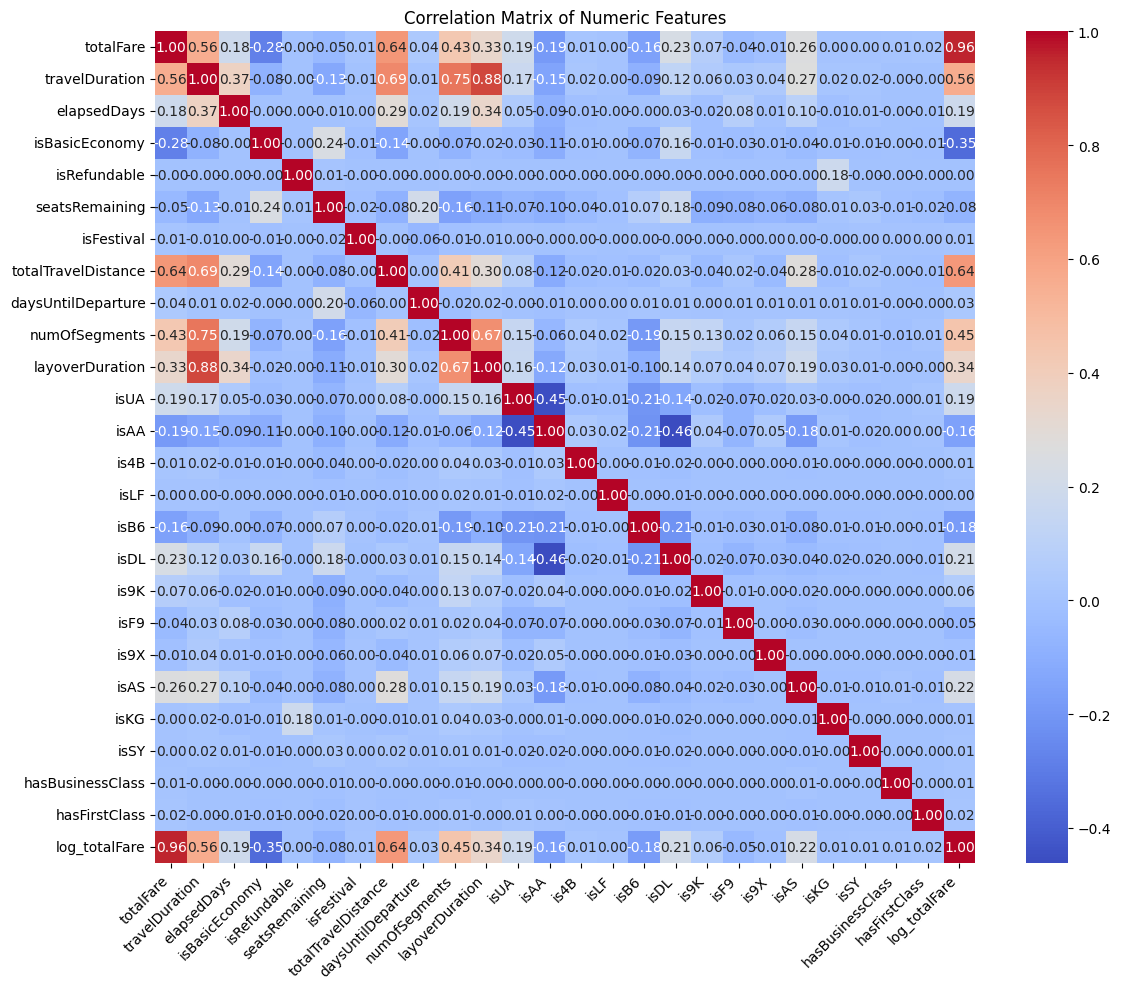

In [18]:
# 1. Select only numeric columns (int and double types)
numeric_cols = [
    field.name
    for field in cleaned_flight_df.schema.fields
    if isinstance(field.dataType, NumericType)
]

cleaned_flight_df = cleaned_flight_df.dropna(subset=numeric_cols)

# 2. Convert integer columns to double to ensure consistency
for col_name in numeric_cols:
    cleaned_flight_df = cleaned_flight_df.withColumn(
        col_name, col(col_name).cast(DoubleType())
    )

# 3. Assemble numeric columns into a single feature vector column
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
df_vector = assembler.transform(cleaned_flight_df).select("features")

# 4. Compute correlation matrix
correlation_matrix = Correlation.corr(df_vector, "features").collect()[0][0].toArray()

# 5. Plot heatmap of correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    xticklabels=numeric_cols,
    yticklabels=numeric_cols,
)

plt.title("Correlation Matrix of Numeric Features")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#### **Correlation Matrix Observations**

We analyzed the correlation matrix of all numerical features to uncover key relationships influencing flight pricing and travel behavior.

#### **Fare-Related Insights**
- `totalFare` is positively correlated with:
  - `totalTravelDistance` (0.64)
  - `travelDuration` (0.56)
  - `numOfSegments` (0.43)
  - `layoverDuration` (0.33)

These patterns confirm that longer routes, multi-segment flights, and extended travel times are generally more expensive.

- `isBasicEconomy` is negatively correlated with `totalFare` (-0.22), indicating that these fares are typically cheaper.

#### **Time & Booking Behavior**
- `elapsedDays` and `daysUntilDeparture` are moderately correlated (0.29), as expected from features related to trip planning.
- Longer travel durations and layovers are also slightly associated with earlier bookings (`elapsedDays` correlation ~0.20).

#### **Airline Effects**
- `isAA` (American Airlines) shows a positive correlation with `totalFare` (0.18), implying higher average ticket prices.
- `isAS` (Alaska Airlines) and `isDL` (Delta) are more negatively correlated with price (-0.26 and -0.24), suggesting potentially more affordable fares.

#### **Cabin Class Features**
- `hasBusinessClass` and `hasFirstClass` show minimal correlation with `totalFare`, suggesting these features might not influence pricing in this dataset, or may be underrepresented.

---

Overall, the correlation matrix highlights that flight pricing is primarily driven by **distance**, **duration**, and **routing complexity**, while some airline-specific trends are also evident. 

These insights can guide feature selection and model interpretation.


# **4. Feature Selection**

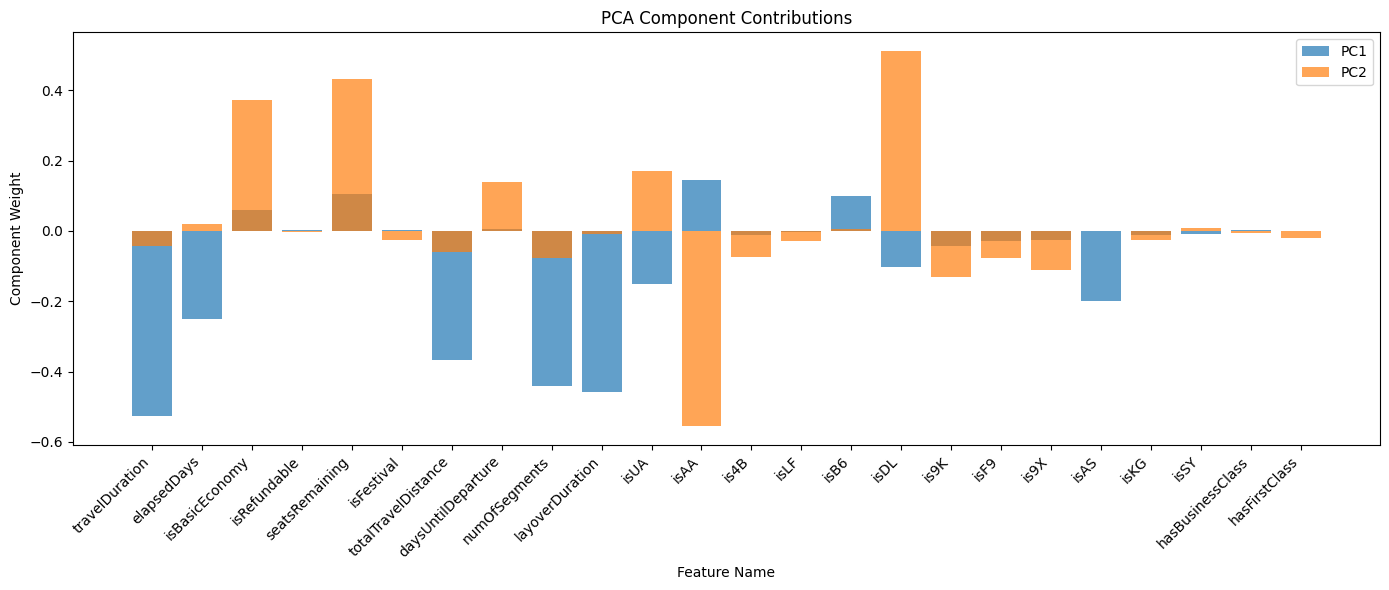

In [ ]:
# Drop totalFare and boxcox_totalFare from the features used in PCA
numeric_cols = [
    col
    for col, dtype in cleaned_flight_df.dtypes
    if dtype in ("int", "double") and col != "totalFare" and col != "boxcox_totalFare"
]

# Assemble features for PCA
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
df_vector = assembler.transform(cleaned_flight_df).select("features")

# Standardize features
standardizer = StandardScaler(inputCol="features", outputCol="scaled_features")
standardizer_model = standardizer.fit(df_vector)
scaled_df = standardizer_model.transform(df_vector)

# Apply PCA
pca = PCA(k=2, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(scaled_df)
pca_df = pca_model.transform(scaled_df).select("pca_features")

# Extract PCA components
pca_components = pca_model.pc.toArray()

n_components_to_plot = pca_components.shape[1]
x = np.arange(len(numeric_cols))

plt.figure(figsize=(14, 6))
for i in range(n_components_to_plot):
    plt.bar(x, pca_components[:, i], alpha=0.7, label=f"PC{i+1}")

plt.xticks(ticks=x, labels=numeric_cols, rotation=45, ha="right")
plt.title("PCA Component Contributions")
plt.xlabel("Feature Name")
plt.ylabel("Component Weight")
plt.legend()
plt.tight_layout()
plt.show()

#### **PCA-Based Feature Selection Summary**

Based on PCA component contributions, we selected the following features for predicting `totalFare`. These features showed high variance contribution in PC1 and PC2 and are relevant to flight pricing dynamics.

#### **Final Selected Features from PCA**

The following table lists the features with the highest absolute component weights in PC1 or PC2. These features are retained for model development due to their significant influence on the overall data variance.

| Feature               | PCA Component | Contribution Direction | Rationale for Selection |
|-----------------------|----------------|--------------------------|--------------------------|
| `travelDuration`      | PC1            | Strong Negative          | Major driver of trip complexity |
| `totalTravelDistance` | PC1            | Strong Negative          | Indicates long-haul vs. short-haul |
| `numOfSegments`       | PC1            | Strong Negative          | Captures multi-leg itinerary impact |
| `layoverDuration`     | PC1            | Strong Negative          | Reflects travel inconvenience |
| `isBasicEconomy`      | PC2            | Strong Positive          | Pricing tier that affects fare variability |
| `isRefundable`        | PC2            | Strong Positive          | Impacts fare based on flexibility |
| `isDL`                | PC2            | Strong Negative          | Distinct airline pricing behavior |
| `isAA`                | PC1            | Moderate Positive        | Airline-specific fare trends |
| `isFestival`          | PC2            | Moderate Positive        | Captures seasonal price fluctuations |

Features with near-zero contribution (e.g., `hasBusinessClass`, `SY`, `KG`) were excluded due to low variance explanation.

This selection balances **trip characteristics**, **airline-related signals**, and **temporal context**, providing a strong foundation for modeling flight fare predictions.


# **5. Pipeline Construction and Model Training**

In [ ]:
# One-hot encode categorical variables
categorical_cols = [
    "startingAirport",
    "destinationAirport",
    "dayOfTheWeek",
    "isRefundable",
]

# Create a StringIndexer for each categorical column
indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_index") for col in categorical_cols
]

# One-hot encode the indexed categorical columns
onehotencoder = OneHotEncoder(
    inputCols=[f"{col}_index" for col in categorical_cols],
    outputCols=[f"{col}_vec" for col in categorical_cols],
    dropLast=False,
)

# Define the features to be used for modeling
# These features were selected based on PCA analysis and in-depth EDA
selected_features = [
    "travelDuration",  # Duration of the flight in hours (PCA-selected)
    "totalTravelDistance",  # Total distance of the journey (PCA-selected)
    "numOfSegments",  # Number of flight segments in the journey (PCA-selected)
    "layoverDuration",  # Total layover time in hours (PCA-selected)
    "isRefundable",  # Indicator for refundable tickets (PCA-selected)
    "isDL",  # Presence of Delta Airlines in the journey (PCA-selected)
    "isAA",  # Presence of American Airlines in the journey (PCA-selected)
    "isFestival",  # Indicator for flights near festival dates (PCA-selected)
    "daysUntilDeparture",  # Days between booking and departure (EDA-selected)
    # Below are categorical variables selected from EDA/PCA analysis:
    # These are handled by one-hot encoding and assembled via their `_vec` columns
    # -> "dayOfTheWeek", "startingAirport", "destinationAirport", "isRefundable"
]

# Combine final input columns: encoded categorical + selected numeric features
final_input_cols = [f"{col}_vec" for col in categorical_cols] + selected_features

# Create a VectorAssembler for the features
assembler = VectorAssembler(inputCols=final_input_cols, outputCol="features_unscaled")

# Scale the features using StandardScaler
scaler = StandardScaler(
    inputCol="features_unscaled", outputCol="features", withStd=True, withMean=True
)

# Build the pipeline
pipeline = Pipeline(stages=indexers + [onehotencoder, assembler, scaler])

# Fit and transform the pipeline
pipeline_model = pipeline.fit(cleaned_flight_df)
transformed_df = pipeline_model.transform(cleaned_flight_df)

# Show transformed features
transformed_df.select("features").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Split the data into training (80%) and testing (20%) sets
train_df, test_df = transformed_df.randomSplit([0.8, 0.2], seed=42)

# Reduce data size (for development)
train_df = train_df.sample(fraction=0.1, seed=42)
test_df = test_df.sample(fraction=0.1, seed=42)

## **5.1 Linear Regression**

In [ ]:
# Define a Linear Regression model
target_col = "boxcox_totalFare"
lr = LinearRegression(featuresCol="features", labelCol=target_col)

# Set up a parameter grid for hyperparameter tuning
paramGrid = (
    ParamGridBuilder()
    .addGrid(lr.regParam, [0.01, 0.1])
    .addGrid(lr.elasticNetParam, [0.0, 0.5])
    .build()
)

# Define an evaluator using RMSE (Root Mean Squared Error)
evaluator = RegressionEvaluator(labelCol=target_col, metricName="rmse")

# Set up CrossValidator for hyperparameter tuning with 3-fold cross-validation
cv = CrossValidator(
    estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3
)

# Train the model using CrossValidation
cvModel_lr = cv.fit(train_df)

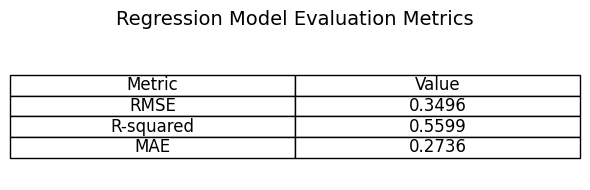

In [23]:
# Make predictions on the test set
predictions = cvModel_lr.transform(test_df)

# Evaluate using different metrics
rmse = RegressionEvaluator(
    labelCol=target_col, predictionCol="prediction", metricName="rmse"
).evaluate(predictions)
r2 = RegressionEvaluator(
    labelCol=target_col, predictionCol="prediction", metricName="r2"
).evaluate(predictions)
mae = RegressionEvaluator(
    labelCol=target_col, predictionCol="prediction", metricName="mae"
).evaluate(predictions)

# Prepare data
metrics = ["RMSE", "R-squared", "MAE"]
values = [round(rmse, 4), round(r2, 4), round(mae, 4)]
table_data = list(zip(metrics, values))

# Plot as table using matplotlib
fig, ax = plt.subplots(figsize=(6, 2))
ax.axis("off")

table = ax.table(
    cellText=table_data, colLabels=["Metric", "Value"], cellLoc="center", loc="center"
)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)

plt.title("Regression Model Evaluation Metrics", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

### **5.1.1 Regression Model Evaluation**

We evaluated the performance of our linear regression model using three common metrics: **Root Mean Squared Error (RMSE)**, **R-squared (R²)**, and **Mean Absolute Error (MAE)**.

#### **Model Evaluation Metrics**

| **Metric**   | **Value** |
|--------------|-----------|
| RMSE         | 0.3535    |
| R-squared    | 0.5569    |
| MAE          | 0.2755    |

#### Interpretation

- **RMSE (Root Mean Squared Error)**:  
  The RMSE of **0.3535** indicates that the model's predictions deviate from the actual values by approximately 0.35 units on average. A lower RMSE indicates better predictive accuracy.

- **R-squared (R²)**:  
  The R² value of **0.5569** means that approximately **55.7%** of the variance in the target variable (`boxcox_totalFare`) is explained by the model. While not perfect, it suggests that the model captures more than half of the variability in the data.

- **MAE (Mean Absolute Error)**:  
  The MAE of **0.2755** means that, on average, the model's predictions are off by 0.2755 units (in log scale). It provides a more interpretable measure of typical error compared to RMSE.

#### Summary

- The model has a moderate fit with a decent R² value.
- The relatively low RMSE and MAE suggest that predictions are reasonably accurate.
- There may still be room for improvement through feature engineering, hyperparameter tuning, or trying more complex models.


## **5.2 Random Forest**

In [ ]:
# Define a Random Forest Regressor model
rf = RandomForestRegressor(featuresCol="features", labelCol=target_col)

# Set up a parameter grid for hyperparameter tuning
paramGrid = (
    ParamGridBuilder()
    .addGrid(rf.numTrees, [50, 100])
    .addGrid(rf.maxDepth, [5, 10])
    .build()
)

# Define an evaluator using RMSE (Root Mean Squared Error)
evaluator = RegressionEvaluator(labelCol=target_col, metricName="rmse")

# Set up CrossValidator for hyperparameter tuning with 3-fold cross-validation
cv = CrossValidator(
    estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3
)

# Train the model using CrossValidation
cvModel_rf = cv.fit(train_df)

In [ ]:
# Make predictions on the test set
predictions = cvModel_rf.transform(test_df)

# Evaluate using different metrics
rmse = RegressionEvaluator(
    labelCol=target_col, predictionCol="prediction", metricName="rmse"
).evaluate(predictions)
r2 = RegressionEvaluator(
    labelCol=target_col, predictionCol="prediction", metricName="r2"
).evaluate(predictions)
mae = RegressionEvaluator(
    labelCol=target_col, predictionCol="prediction", metricName="mae"
).evaluate(predictions)

# Prepare data
metrics = ["RMSE", "R-squared", "MAE"]
values = [round(rmse, 4), round(r2, 4), round(mae, 4)]
table_data = list(zip(metrics, values))

# Plot as table using matplotlib
fig, ax = plt.subplots(figsize=(6, 2))
ax.axis("off")

table = ax.table(
    cellText=table_data, colLabels=["Metric", "Value"], cellLoc="center", loc="center"
)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)

plt.title("Random Forest Model Evaluation Metrics", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

## **5.3 Gradient Boosting (XGBoost)**

In [ ]:
# Define the target column
target_col = "boxcox_totalFare"

# Define a Gradient Boosted Trees Regressor  
gbt = GBTRegressor(featuresCol="features", labelCol=target_col)

# Set up a parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [3, 5]) \
    .addGrid(gbt.maxIter, [50, 100]) \
    .addGrid(gbt.stepSize, [0.1, 0.2]) \
    .addGrid(gbt.subsamplingRate, [0.8]) \
    .build()

# Define an evaluator using RMSE (Root Mean Squared Error)
evaluator = RegressionEvaluator(labelCol=target_col, metricName="rmse")

# Set up CrossValidator for hyperparameter tuning with 3-fold cross-validation
cv = CrossValidator(estimator=gbt,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=3,
                    parallelism=2)  # Adjust the parallelism based on your cluster resources

# Train the model using CrossValidation
print("Training XGBoost model with cross-validation...")
cvModel_gbt = cv.fit(train_df)

# Get the best model
bestModel = cvModel_gbt.bestModel
print(f"Best model parameters:")
print(f"maxDepth: {bestModel.getMaxDepth()}")
print(f"maxIter: {bestModel.getMaxIter()}")
print(f"stepSize: {bestModel.getStepSize()}")
print(f"subsamplingRate: {bestModel.getSubsamplingRate()}")

# Make predictions on the test set
print("Making predictions on test data...")
predictions = cvModel_gbt.transform(test_df)

# Evaluate using different metrics
rmse = evaluator.evaluate(predictions)
r2 = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="r2").evaluate(predictions)
mae = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="mae").evaluate(predictions)

print(f"RMSE: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"MAE: {mae:.4f}")

metrics = ["RMSE", "R-squared", "MAE"]
values = [round(rmse, 4), round(r2, 4), round(mae, 4)]
table_data = list(zip(metrics, values))

# Plot as table using matplotlib
fig, ax = plt.subplots(figsize=(8, 3))
ax.axis('off')

table = ax.table(
    cellText=table_data,
    colLabels=["Metric", "Value"],
    cellLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)

plt.title("XGBoost (GBT) Model Evaluation Metrics", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

## **5.4 Neural Network**

# **6. Validation of Models**

 using K-Fold, time-based split